In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
#import transformers
#from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import h5py
import json

import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from random import shuffle,randint

from scipy.fftpack import fft
import scipy.stats as stats
import scipy.io as scio
from scipy.io import wavfile
from scipy import signal
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


from tqdm import tqdm
from torchmetrics.functional import word_error_rate as wer
from textwrap import wrap
import textgrid as tg
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch
from torch import nn, optim, einsum
import torch.utils.data as Data
from torch.utils.data import DataLoader,TensorDataset
import wave


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
date='1123'
print(date)
subject = 'PA4'

1123


In [3]:
#FUNCTIONS USED TO LOAD DATA
from torch.utils.data import ConcatDataset
def get_timelocked_activity(times, hg, back, forward, hz=False):
    '''
    Get time-locked activity.

    Parameters:
    - times (array-like): List of timepoints in seconds.
    - hg (numpy.ndarray): High gamma array, shaped (elecs_num, whole_duration*hz).
    - back (float): Start time before the timepoints.
    - forward (float): End time after the timepoints.
    - hz (float, optional): Sampling rate of High gamma. Default is False.

    Returns:
    - Y_mat (numpy.ndarray): Time-locked activity array, shaped (trial_num, elecs_num, selected_duration*hz).
    - back (int): Start time in samples (back*hz).
    - forward (int): End time in samples (forward*hz).
    '''
    if hz:
        times = (times*hz).astype(int)
        back = int(back*hz)
        forward = int(forward*hz)
    times = times[times - back > 0]
    times = times[times + forward < hg.shape[1]]

    Y_mat = np.zeros((len(times),hg.shape[0], int(back + forward)), dtype=float)

    for i, index in enumerate(times):
        Y_mat[i, :, :] = hg[:, int(index-back):int(index+forward)]

    return Y_mat,back,forward

def read_ecog_mat(back,forward,mat,channelNum,key_elecs=[],key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[],oppoparagraph=False,
                  hz=False, block=4):
    '''
    get ecog_mat based on defined parameters
    
    Parameters:
    - mat : shaped(7,num_of_timepoints)
    - hg (numpy.ndarray): High gamma array, shaped (elecs_num, whole_duration*hz).
    - back (float): Start time before the timepoints.
    - forward (float): End time after the timepoints.
    - hz (float, optional): Sampling rate of High gamma. Default is False.
    channelNum:number of electrodes 128 or 256
    block:number of blocks included, usually from 1 to 4
    key_elecs: selected elecs
    kay_labels:selected labels, opplabel means oppose the key_label
    sentence and paragraphs similarly
    '''

    key_elecs = np.array(key_elecs)
    key_index = np.ones(len(mat[0,:])).astype('bool')
    
    sentence_index = np.ones(len(mat[0,:])).astype('bool')
    label_index = np.ones(len(mat[0,:])).astype('bool')
    paragraph_index = np.ones(len(mat[0,:])).astype('bool')  
    
    if key_label:
        print('select label:'+str(key_label),end=' ')
        label_index=~label_index
        for i in key_label:
            temp_index = mat[0,:] ==i
            label_index = np.logical_or(label_index, temp_index)
        if oppolabel:
            print('oppo')
            label_index=~label_index
    key_index = np.logical_and(label_index, key_index)
    if key_sentence:
        print('select sentence:'+str(key_sentence),end=' ')
        sentence_index=~sentence_index
        for i in key_sentence:
            temp_index = mat[2,:] ==i
            sentence_index = np.logical_or(sentence_index, temp_index)
        if opposentence:
            print('oppo')
            sentence_index=~sentence_index
    key_index = np.logical_and(sentence_index, key_index)        
    if key_paragraph:
        print('select paraqraph:'+str(key_paragraph),end=' ')
        paragraph_index=~paragraph_index
        for i in key_paragraph:
            temp_index = mat[3,:] ==i
            paragraph_index = np.logical_or(paragraph_index, temp_index)
        if oppoparagraph:
            print('oppo')
            paragraph_index=~paragraph_index
    key_index = np.logical_and(paragraph_index, key_index)      
    mat = mat[:,key_index]
       
    
    if key_elecs.any():
        ecog_mat = np.zeros((len(mat[0,:]),len(key_elecs), int((back+forward)*hz)), dtype=float)
        print('select elecs:'+str(key_elecs),end=' ')
    else:
        ecog_mat = np.zeros((len(mat[0,:]),channelNum, int((back+forward)*hz)), dtype=float)
        
    for i in range(block):
        block_index= mat[4,:]==i+1
        temp_time_list=mat[1,block_index]
        ecogData=scio.loadmat(path_raw+str(i+1)+filterType+'.mat')#################################
        ecogData=np.array(ecogData['bands'])*10e4
        #print('###',np.nanmean(np.max(ecogData,axis=1)-np.min(ecogData,axis=1)),np.array(np.max(ecogData,axis=1)).shape)######################################################################################
        temp_ecog,back_duration,forward_duration = get_timelocked_activity(times=temp_time_list, hg=ecogData, back=back, forward=forward, hz=hz)
        if key_elecs.any():
            key_elecs = np.array(key_elecs)
            ecog_mat[block_index] = temp_ecog[:,key_elecs,:]
        else:
            ecog_mat[block_index] = temp_ecog

    print('read_ecog:',ecog_mat.shape)
    return ecog_mat,back_duration,forward_duration,mat

'''
EXAMPLE:
ecog_mat,back_duration,forward_duration,mat = read_ecog_mat(back,forward,mat,channelNum,key_elecs=[],
                key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[],oppoparagraph=False,
                hz=False, block=4)
'''


'\nEXAMPLE:\necog_mat,back_duration,forward_duration,mat = read_ecog_mat(back,forward,mat,channelNum,key_elecs=[],\n                key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=[],oppoparagraph=False,\n                hz=False, block=4)\n'

In [4]:
#FUNCTIONS USED TO TRAIN AND VALIDATE THE MODEL
# generate datasets for cross-validation in evaluation stage
def CV_val_datasets(back,forward,mat,key_elecs,row,CV_list,unbalance=False,List=False,augmented=False):
    CV_datasets = []
    CV_augmented_datasets=[]
    count_total=[]

    for CVs in range(len(CV_list)):
        print('mat:',mat.shape)
        test_ecog_mat,_,_,test_mat= read_ecog_mat(back=back,forward=forward,mat=mat,channelNum=channelNum,key_elecs=key_elecs,
                key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=CV_list[CVs],oppoparagraph=False,
                hz=hz, block=4)

        test_label = test_mat[row,:]
        
        if unbalance == True:
            count=np.bincount(test_label.astype('int'))
            if len(count)!=len(List):
                print('not a full set!')
                dataPlus1 = np.concatenate((data,np.arange(len(List))))
                count=np.bincount(dataPlus1)-1    
                del dataPlus1
            print(count)
            count_total.append(count)
        test_ecog_mat=torch.FloatTensor(test_ecog_mat)
        test_label=torch.tensor(test_label,dtype=torch.long)
        testdataset = Data.TensorDataset(test_ecog_mat, test_label)    
        CV_datasets.append(testdataset)
        

        if augmented is not False:
            aug_mat = stammer (mat=test_mat, multiple_time=augmented,multiple_range=0.01,shift=-0.005)
            aug_ecog_mat,_,_,test_mat= read_ecog_mat(back=back,forward=forward,mat=mat,channelNum=channelNum,key_elecs=key_elecs,
                key_label=[],oppolabel=False,key_sentence=[],opposentence=False, key_paragraph=CV_list[CVs],oppoparagraph=False,
                hz=hz, block=4)
            aug_label = aug_mat[row,:]
            aug_ecog_mat=torch.FloatTensor(aug_ecog_mat)
            aug_label=torch.tensor(aug_label,dtype=torch.long)
            augdataset = Data.TensorDataset(aug_ecog_mat, aug_label) 
            CV_augmented_datasets.append(augdataset)
    if unbalance == True:
        count_total = np.array(count_total)
    return CV_datasets,count_total,CV_augmented_datasets

# cross-validation in evaluation stage for speech detector
def CV_val_onset( CV_datasets, lr, batch_size, patience, class_weight, val_ratio, channelNum=256):
    loss_func = nn.CrossEntropyLoss()

    acc_list=[]
    loss_list=[]
    label_list=[]
    test_out_list=[]
    test_out_prob_list=[]

    for test_CV in [12,13,14,15]:#tqdm(

        CV_train_val_datasets = CV_datasets.copy()
        CV_test_datasets = [CV_train_val_datasets.pop(test_CV),]
        
        CV_train_datasets = []
        CV_val_datasets = []
        for train_val_dataset in CV_train_val_datasets:
            val_size = int(val_ratio * len(train_val_dataset))
            train_size = len(train_val_dataset) - val_size
            train_dataset, val_dataset = Data.random_split(train_val_dataset, [train_size, val_size])
            CV_train_datasets.append(train_dataset)
            CV_val_datasets.append(val_dataset)
        #label,acc,predicted,predicted_prob, predicted_only,predicted_only_prob, model,loss_func.cpu()
        label,_,_,predicted_prob,_,_,_,_ = train(
                                        lr=lr, batch_size=batch_size, EPOCH=EPOCH, patience=patience, 
                                        CV_train_datasets = CV_train_datasets, #CV_train_val_datasets, #
                                        CV_val_datasets =  CV_val_datasets, #False, #
                                        CV_test_datasets = CV_test_datasets,#False, 
                                        pred_only_datasets = False, #pred_only_datasets, 
                                        class_weight=class_weight)
            
        #predicted_prob_list.append(predicted_prob)
        #predicted_prob = np.mean(predicted_prob_list, axis=0)
        
        loss = loss_func(torch.tensor(predicted_prob), torch.tensor(label))
        loss = loss / len(label)
        predicted = np.argmax(predicted_prob, axis=1)
        correct = np.sum(predicted == np.array(label))
        acc = correct / len(label)
        #tune.track.log(loss=loss)####################################################
       
        
        acc_list.append(acc)
        loss_list.append(loss)
        label_list.extend(label)
        test_out_list.extend(predicted) 
        test_out_prob_list.extend(predicted_prob) 
        plotCM(List = stateList,test_acc_list=acc_list,test_label_list=label_list,test_out_list=test_out_list)
        
    return acc_list, loss_list, label_list, test_out_prob_list
'''
_, _, _, onset_prob = CV_train_onset(CV_datasets=CV_onset_datasets, 
                                    lr, batch_size, patience, 
                                    class_weight, val_ratio, 
                                    channelNum=256)
'''
# cross-validation in evaluation stage for tone and syllable detector, with 10 ensumble networks
def CV_val_ENN(CV_datasets, CV_pred_only_datasets, lr, batch_size, patience,
                 class_weight = False, channelNum=256):
    
    loss_func = nn.CrossEntropyLoss()

    acc_list=[]
    loss_list=[]
    label_list=[]
    test_out_list=[]
    test_out_prob_list=[]
    pred_only_list=[]
    pred_only_prob_list=[]

    for test_CV in [0,1,2,3]:#tqdm(
        CV_train_val_datasets = CV_datasets.copy()
        CV_test_datasets = [CV_train_val_datasets.pop(test_CV+4),]
        pred_only_datasets = [CV_pred_only_datasets[test_CV],]
        
        combined_dataset = ConcatDataset(CV_train_val_datasets[-3:])
        CV_train_val_datasets[-3:] = [combined_dataset]
        
        #model_list=[]
        predicted_prob_list = []
        predicted_only_prob_list= []
        for double in range(2):
            for CVs in range(5):
                CV_train_datasets = CV_train_val_datasets.copy()
                CV_val_datasets = [CV_train_datasets.pop(CVs),]
                #label,acc,predicted,predicted_prob, predicted_only,predicted_only_prob,model
                label,acc,_,predicted_prob,_,predicted_only_prob,CV_model,loss_func= train(lr=lr, batch_size=batch_size, EPOCH=EPOCH, patience=patience, 
                                            CV_train_datasets = CV_train_datasets, #CV_train_val_datasets, #
                                            CV_val_datasets =  CV_val_datasets, #False, #
                                            CV_test_datasets = CV_test_datasets,#False, 
                                            pred_only_datasets = pred_only_datasets, 
                                            class_weight=class_weight)
            
                #model_list.append(CV_model)
                predicted_prob_list.append(predicted_prob)
                predicted_only_prob_list.append(predicted_only_prob)
            
        predicted_prob = np.mean(predicted_prob_list, axis=0)
        predicted_only_prob = np.mean(predicted_only_prob_list, axis=0)
        loss_func = loss_func.cpu() 
        loss = loss_func(torch.tensor(predicted_prob), torch.tensor(label))
        loss = loss / len(label)
        predicted = np.argmax(predicted_prob, axis=1)
        predicted_only = np.argmax(predicted_only_prob, axis=1)
        correct = np.sum(predicted == np.array(label))
        acc = correct / len(label)

        acc_list.append(acc)
        loss_list.append(loss)
        label_list.extend(label)
        test_out_list.extend(predicted) 
        test_out_prob_list.extend(predicted_prob) 
        pred_only_list.extend(predicted_only) 
        pred_only_prob_list.extend(predicted_only_prob) 
        #if stage=='sylb':
            #plotCM(List = sylbList,test_acc_list=acc_list,test_label_list=label_list,test_out_list=test_out_list)###########
        #elif stage=='tone':
            #plotCM(List = toneList,test_acc_list=acc_list,test_label_list=label_list,test_out_list=test_out_list)#############
    return acc_list, loss_list, label_list, test_out_prob_list, pred_only_list, pred_only_prob_list

'''

_,_,_,_,pred_only_list,pred_only_prob_list = CV_train_ENN( 
                               CV_datasets = CV_sylb_datasets, 
                               CV_pred_only_datasets = CV_clip_datasets,
                               lr=lr_sylb, batch_size=batch_size_sylb, patience=patience,
                               class_weight = False, channelNum=256):
'''
# perform cross validation on monosyllabic model
def CV_val_RES( CV_datasets, CV_pred_only_datasets, lr, batch_size, patience, class_weight, val_ratio, channelNum=256):
    loss_func = nn.CrossEntropyLoss()

    acc_list=[]
    loss_list=[]
    label_list=[]
    test_out_list=[]
    test_out_prob_list=[]
    pred_only_prob_list = []

    for test_CV in [12,13,14,15]:#tqdm(

        CV_train_val_datasets = CV_datasets.copy()
        CV_test_datasets = [CV_train_val_datasets.pop(test_CV),]
        CV_pred_datasets =  [CV_pred_only_datasets[test_CV-12],]
        
        CV_train_datasets = []
        CV_val_datasets = []
        for train_val_dataset in CV_train_val_datasets:
            val_size = int(val_ratio * len(train_val_dataset))
            train_size = len(train_val_dataset) - val_size
            train_dataset, val_dataset = Data.random_split(train_val_dataset, [train_size, val_size])
            CV_train_datasets.append(train_dataset)
            CV_val_datasets.append(val_dataset)
        #label,acc,predicted,predicted_prob, predicted_only,predicted_only_prob, model,loss_func.cpu()
        label,acc,_,predicted_prob,_,predicted_only_prob,CV_model,loss_func= train(
                                        lr=lr, batch_size=batch_size, EPOCH=EPOCH, patience=patience, 
                                        CV_train_datasets = CV_train_datasets, #CV_train_val_datasets, #
                                        CV_val_datasets =  CV_val_datasets, #False, #
                                        CV_test_datasets = CV_test_datasets,#False, 
                                        pred_only_datasets = CV_pred_datasets, #pred_only_datasets, 
                                        class_weight=class_weight)
            
        #predicted_prob_list.append(predicted_prob)
        #predicted_prob = np.mean(predicted_prob_list, axis=0)
        
        loss = loss_func(torch.tensor(predicted_prob), torch.tensor(label))
        loss = loss / len(label)
        predicted = np.argmax(predicted_prob, axis=1)
        correct = np.sum(predicted == np.array(label))
        acc = correct / len(label)
        #tune.track.log(loss=loss)####################################################
       
        
        acc_list.append(acc)
        loss_list.append(loss)
        label_list.extend(label)
        test_out_list.extend(predicted) 
        test_out_prob_list.extend(predicted_prob) 
        pred_only_prob_list.extend(predicted_only_prob)
        #plotCM(List = stateList,test_acc_list=acc_list,test_label_list=label_list,test_out_list=test_out_list)
        
    return acc_list, loss_list, label_list, test_out_prob_list, pred_only_prob_list


def train(batch_size, lr, EPOCH, patience, CV_train_datasets, 
          CV_val_datasets=False, CV_test_datasets=False, pred_only_datasets=False, 
          class_weight=False):
    #This function directly train and validate the model
    model = torch.load("./"+subject+'.pt')
    loss_func = nn.CrossEntropyLoss() 
    if class_weight is not False:
        weight = [max(class_weight)/x for x in class_weight]
        weight = torch.FloatTensor(weight).to(device)
        loss_func = nn.CrossEntropyLoss(weight=weight)
        
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    
    early_stopping = EarlyStopping(patience)
    '''
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer,T_max =  EPOCH)
    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, 
                                           verbose=False, threshold=0.0001, threshold_mode='rel', 
                                           cooldown=0, min_lr=0, eps=1e-08)
    '''
    for epoch in range(EPOCH):
        #return acc，ground truth & predicited label
        sum_loss_train= 0
        total_train=0
        model.train()
        for train_dataset in CV_train_datasets:
            train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                pred = model(inputs)
                loss = loss_func(pred, labels)
                sum_loss_train+= loss.item()
                total_train+= labels.size(0)
                loss.backward()
                optimizer.step()
        train_loss = sum_loss_train/total_train
        if verbose:
            print('Epoch {}:train-loss:{:.2e},'.format(epoch+1,train_loss),end='')
       
        if CV_val_datasets is not False:#if there is val datasets performing early-stopping
            sum_loss_val=0
            total_val = 0  
            for val_dataset in CV_val_datasets:
                val_loader = Data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
                for data in val_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device) 
                    pred = model(inputs)
                    loss = loss_func(pred, labels)
                    sum_loss_val+=loss.item()
                    total_val+= labels.size(0)
            val_loss = sum_loss_val/total_val
            if verbose:
                print('val-loss:{:.2e},'.format(val_loss,),end='')
            
            '''
            scheduler.step(val_loss)##############################################
            #scheduler.step()
            '''
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                if verbose:
                    print("Early stopping")
                break
        
        if CV_test_datasets is not False: #if there is test data for testing
            total_test = 0  
            sum_loss_test= 0
            predicted=[]
            label=[]
            
            for test_dataset in CV_test_datasets:
                test_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                for data in test_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device)
                    pred_prob = model(inputs)
                    loss = loss_func(pred_prob, labels)
                    sum_loss_test+=loss.item()
                    _, pred = torch.max(pred_prob.data, 1)
                    pred_prob = pred_prob.data
                    pred_prob = F.softmax(pred_prob, dim=1) 
                    total_test+= labels.size(0)
                    predicted.append(pred.cpu())
                    label.append(labels.cpu())
            label = torch.cat(label,dim=0)
            predicted = torch.cat(predicted,dim=0)
            correct = (predicted == label).sum()
            test_acc= correct.item()/total_test
            test_loss=sum_loss_test/total_test
            if verbose:
                print('test-loss:{:.2e},Acc:{:.4f}'.format(test_loss,test_acc),end='')
        if verbose:
            print('')
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    ##############################EVALUATION model###############################################
    predicted=[]
    predicted_prob=[]
    label=[]
    acc=[]
    if CV_test_datasets is not False:
        total_test = 0  
        sum_loss_test= 0
        model.eval()
        for test_dataset in CV_test_datasets:
            test_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  
                pred_prob = model(inputs)
                loss = loss_func(pred_prob, labels)
                sum_loss_test+=loss.item()
                _, pred = torch.max(pred_prob.data, 1)
                pred_prob = pred_prob.data
                pred_prob = F.softmax(pred_prob, dim=1) 
                total_test+= labels.size(0)

                predicted.append(pred.cpu())
                predicted_prob.append(pred_prob.cpu())
                label.append(labels.cpu())

        label = torch.cat(label,dim=0)
        predicted = torch.cat(predicted,dim=0)
        predicted_prob = torch.cat(predicted_prob,dim=0)
        correct = (predicted == label).sum()
        test_acc= correct.item()/total_test
        test_loss=sum_loss_test/total_test
        if verbose:
            print('Final: test-loss:{:.2e},Acc:{:.4f}'.format(test_loss,test_acc))
        label = label.detach().numpy()
        acc = test_acc
        predicted = predicted.detach().numpy()
        predicted_prob = predicted_prob.detach().numpy()
    
    
    ##PRED-ONLY:do not return acc, only predicted result
    predicted_only=[]
    predicted_only_prob=[]
        
    if pred_only_datasets is not False:
        for pred_only_dataset in pred_only_datasets:
            pred_only_loader = Data.DataLoader(pred_only_dataset, batch_size=batch_size, shuffle=False)
            for inputs in pred_only_loader:
                inputs = inputs[0].to(device)
                pred = model(inputs)
                pred_only_prob = pred.data
                pred_only_prob = F.softmax(pred_only_prob, dim=1) 
                _, pred_only = torch.max(pred.data, 1)
                predicted_only.append(pred_only.cpu())
                predicted_only_prob.append(pred_only_prob.cpu())
            
        predicted_only = torch.cat(predicted_only).detach().numpy()
        predicted_only_prob = torch.cat(predicted_only_prob).detach().numpy()
        if verbose:
            print(predicted_only_prob.shape)
    
    return label,acc, predicted,predicted_prob, predicted_only,predicted_only_prob, model,loss_func.cpu()

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping: {self.counter}/{self.patience}',end='')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), 'checkpoint.pt')	# save the best model
        self.val_loss_min = val_loss

# calculate loss, Acc and confusion matrix for syllable and tone decoder  
def evaluater(Mat, prob_list, loss_func = nn.CrossEntropyLoss(), unit = 3):
    
    if stage in ['sylb','onset_sylb']:
        List = sylbList
        row = 0
    elif stage in ['tone','onset_tone']:
        List = toneList
        row = 5
        
    real_indices = np.where(~np.isnan(Mat[0, :]))[0]
    Mat =  Mat[:, real_indices]
    prob_list = np.array(prob_list)[np.array(real_indices)]
    
    acc_list=[]
    loss_list=[]
    for trial in set(Mat[unit,:]):
        trial_index = Mat[3,:]==trial
        temp_label = Mat[row,trial_index]
        temp_prob = prob_list[trial_index]

        loss = loss_func(torch.tensor(temp_prob), torch.tensor(temp_label, dtype=torch.long))
        loss = loss / len(temp_label)
        temp_out = np.argmax(temp_prob, axis=1)
        correct = np.sum(temp_out == np.array(temp_label))
        acc = correct / len(temp_label)

        acc_list.append(acc)
        loss_list.append(loss)
    
    if plot:
        plotCM(List, acc_list, Mat[row,:], np.argmax(prob_list, axis=1))

    return acc_list, loss_list

# calculate loss, Acc and confusion matrix for final outcomes of tonal syllables and Chinese characters 
def evaluater2(Mat, out_list, unit=3):
    
    real_indices = np.where(~np.isnan(Mat[0, :]))[0]
    Mat =  Mat[:, real_indices]
    out_list = np.array(out_list)[np.array(real_indices)]
    
    if stage in ['sylb_tone', 'onset_sylb_tone']:
        true_char = [sylbList[int(Mat[0, i])] + toneList[int(Mat[5, i])] for i in range(Mat.shape[1])]
    elif stage in ['char', 'onset_char']:
        true_char = [charList[int(Mat[6, i])] for i in range(Mat.shape[1])]
    else:
        print('stage not applicable')
        return 0
    #print(len(true_char),len(out_list.shape))
    #print(true_char,out_list)
    acc_list=[]
    trial_list=[]
    for trial in set(Mat[unit,:]):
        trial_index = Mat[unit, :] == trial
        temp_label = np.array(true_char)[trial_index]  # Use np.array(true_char) to convert to numpy array
        temp_out = np.array(out_list)[trial_index]  # Use np.array(out_list) to convert to numpy array
        correct = np.sum(temp_out == temp_label)
        acc = correct / len(temp_label)
        acc_list.append(acc)
        trial_list.append(trial)

    if plot:
        plotCM2(true_char, out_list, acc_list)
        
    return acc_list, trial_list
'''
stage = 'onset_sylb_tone'
sylb_tone_out, pred_prob_char = sylbTone2char(np.array(sylb_pred_only_prob_list).T,
                                          np.array(tone_pred_only_prob_list).T)
evaluater2(clipTimeMat, sylb_tone_out, unit=3)


stage = 'sylb_tone'
fix_sylb_tone_out, fix_pred_prob_char = sylbTone2char(np.array(sylb_test_out_prob_list).T,
                                          np.array(tone_test_out_prob_list).T)
evaluater2(sylb_label_mat, fix_sylb_tone_out, unit=3)
'''
# plot confusion matrix for speech detector, syllable and tone decoder
def plotCM(List,test_acc_list,test_label_list,test_out_list,wer_list=False,save = False):

    C2= confusion_matrix(test_label_list, test_out_list,normalize='true')#,
    #C2= confusion_matrix(test_out, predicted,normalize='true')#test_out->
    labels=List
    print(C2)
    disp = ConfusionMatrixDisplay(confusion_matrix = C2, display_labels=labels)
    fig=plt.figure()
    fig.set_size_inches(200,200)
    disp.plot()
    plt.title('N='+str(len(test_acc_list))+"  Acc:%0.2f±%0.2f" % (np.mean(test_acc_list),np.std(test_acc_list)))
    if save:
        plt.savefig(subject+'_'+stage +'.png', bbox_inches='tight')
    return 0

'''
plotCM(List = stateList,test_acc_list=[],test_label_list=overt_test_label_list,test_out_list=overt_test_out_list,paraNum=paraNum)
'''
# plot confusion matrix for tonal syllable and Chinese character
def plotCM2(true_char, pred_char,test_acc_list, save = False):
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    true_char = np.array(true_char)
    pred_char = np.array(pred_char)

    # Define the desired order of labels
    unique_labels = ['shi1', 'shi2', 'shi3', 'shi4', 'de1', 'de2', 'de3', 'de4', 'ji1', 'ji2', 'ji3', 'ji4', 
                     'li1', 'li2', 'li3', 'li4', 'bu1', 'bu2', 'bu3', 'bu4', 'ge1', 'ge2', 'ge3', 'ge4', 
                     'qi1', 'qi2', 'qi3', 'qi4', 'zhe1', 'zhe2', 'zhe3', 'zhe4', 'ta1', 'ta2', 'ta3', 'ta4', 
                     'zhi1', 'zhi2', 'zhi3', 'zhi4','失', '十', '时', '实', '是', '的', '地', '得', '机', '激',
                     '极', '记', '计', '迹', '离', '里', '理', '励', '荔', '不',
                     '布', '哥', '搁', '个', '七', '奇', '其', '起', '契', '折',
                     '者', '这', '他', '塔', '织', '枝', '职', '止', '置', '智',]

    # Filter out labels that do not appear in true_char or pred_char
    unique_labels_filtered = [label for label in unique_labels if label in np.concatenate((true_char, pred_char))]

    # Map each element in true_char to its corresponding index in unique_labels_filtered
    labels = [unique_labels_filtered.index(label) for label in true_char]

    # Convert pred_char to integers based on unique_labels_filtered
    pred_labels = [unique_labels_filtered.index(label) for label in pred_char]

    C2 = confusion_matrix(labels, pred_labels, normalize='true')

    disp = ConfusionMatrixDisplay(confusion_matrix=C2, display_labels=unique_labels_filtered)

    #sns.set(font='WenQuanYi Micro Hei')
    sns.set_style("whitegrid", {"axes.grid": False, "grid.alpha": 0})
    
    fig, ax = plt.subplots(figsize=(30, 30))
    disp.plot(ax=ax)
    
    plt.title('N='+str(len(test_acc_list))+"  Acc:%0.2f±%0.2f" % (np.mean(test_acc_list),np.std(test_acc_list)))
    if save:
        plt.savefig(subject+'_'+stage+'.png', bbox_inches='tight')
    plt.show()
    return 0

# calvulate word error rate for each sentences
def wer_evaluater(Mat1, Mat2, char_out):####################for 13-16trials evaluations only
    char_out = np.array(char_out)
    wer_mat = np.full((len(np.unique(Mat1[3,:])),len(np.unique(Mat1[2,:]))), np.nan)
    for trial in set(Mat1[3,:]):
        trial_index = Mat1[3,:]==trial
        trial_index2 = Mat2[3,:]==trial
        for sentence in set(Mat1[2,:]):
            print(sentence)
            sentence_index = Mat1[2,:]==sentence
            sentence_index2 = Mat2[2,:]==sentence
            # Create a logical condition for indices that satisfy both trial_index and sentence_index
            condition = np.logical_and(trial_index, sentence_index)
            indices = np.where(condition)[0]
            condition = np.logical_and(trial_index2, sentence_index2)
            indices2 = np.where(condition)[0]
            true_temp = np.array([charList[int(i)] for i in Mat1[6, indices]])
            pred_temp = char_out[indices2]
            
            true_temp = " ".join(true_temp.tolist())
            pred_temp = " ".join(pred_temp.tolist())
            wer_score = wer(pred_temp, true_temp)
            
            true_temp_padded = true_temp.ljust(30)
            pred_temp_padded = pred_temp.ljust(30)
            wer_formatted = '{:.2f}'.format(wer_score.item()).ljust(5)
            print('True: {} Pred: {} WER: {}'.format(true_temp_padded, pred_temp_padded, wer_formatted))
            
            wer_mat[int(trial)-13][int(sentence)-1] = wer_score.item()
            
    return wer_mat
'''
wer_mat = wer_evaluater(sylb_label_mat, clipTimeMat, char_out)
'''

'\nwer_mat = wer_evaluater(sylb_label_mat, clipTimeMat, char_out)\n'

In [5]:
# FUNCTIONS FOR DATA PROCESSING AND INTEGRATION
def slicer(interval, test_mat, predicted, sylb_mat,
           smooth_window = 0.04,
           smooth_threshold = 0.6,
           onset_duration = 0.08,
           offset_duration = 0.08,
           word_duration = 0.5,eps = 0.05):
    delta = 0.25
    predicted = np.array(predicted)
    hwd=int(smooth_window*hz/2)
    smooth_out=predicted.copy()
    for i in range(hwd,len(predicted)-hwd+1):
        smooth_out[i]=np.nanmean(predicted[i-hwd:i+hwd])
    bi_out=smooth_out>smooth_threshold
    
    clipTimeIndex=[]
    stableOnset=onset_duration//interval
    stableOffset = offset_duration//interval
    sayAword=word_duration//interval

    i = int(onset_duration)
    while i < len(bi_out)-stableOnset:
        if bi_out[i]==1 and bi_out[i-1]==0:
            if np.mean(bi_out[i:int(i+stableOnset)])>1-eps:
                if np.mean(bi_out[int(i-stableOffset):i])<eps:
                    clipTimeIndex.append(i)
                    i+=int(sayAword-1)
        i+=1
    
    clipTimeIndex = np.array(clipTimeIndex)
    clipTimeMat = np.zeros((7,len(clipTimeIndex)))
    print(clipTimeMat.shape)
    clipTimeMat[1:5,:] = test_mat[1:,clipTimeIndex]
    print(clipTimeMat.shape)
    
    trial_values = set(test_mat[3,:])
    for trial in trial_values:
        temp_sylb_mat = sylb_mat[:,sylb_mat[3,:]==trial]
        temp_sylb_time = temp_sylb_mat[1,:]
        print(temp_sylb_mat.shape,temp_sylb_time.shape)
        temp_onset_time = clipTimeMat[1,clipTimeMat[3,:]==trial]
        index=[]
        for t in temp_onset_time:
            idx = np.searchsorted(temp_sylb_time, t)
            if idx == 0:
                diff1 = np.abs(t - temp_sylb_time[0])
                if diff1 <= delta:
                    closest_idx = 0
                else:
                    closest_idx = np.nan
            elif idx == len(temp_sylb_time):
                diff1 = np.abs(t - temp_sylb_time[-1])
                if diff1 <= delta:
                    closest_idx = idx - 1
                else:
                    closest_idx = np.nan
            else:
                diff1 = np.abs(t - temp_sylb_time[idx - 1])
                diff2 = np.abs(t - temp_sylb_time[idx])
                if diff1 <= delta and diff2 <= delta:
                    closest_idx = idx - 1 if diff1 < diff2 else idx
                elif diff1 <= delta:
                    closest_idx = idx - 1
                elif diff2 <= delta:
                    closest_idx = idx
                else:
                    closest_idx = np.nan
            index.append(closest_idx)

        index = np.array(index)
        print(index)
        nan_indices = np.isnan(index)
        result = np.empty((3, len(index)), dtype=float)
        result[:, nan_indices] = np.nan
        valid_indices = ~nan_indices
        valid_indices = np.array(valid_indices)
        valid_index = index[valid_indices].astype(int)
        temp_sylb_mat_indices = np.array([0, 5, 6])[:, np.newaxis]
        result[:, valid_indices] = temp_sylb_mat[temp_sylb_mat_indices, valid_index]
        
        
        clipTimeMat[0, clipTimeMat[3, :] == trial] = result[0,:]
        clipTimeMat[5, clipTimeMat[3, :] == trial] = result[1,:]
        clipTimeMat[6, clipTimeMat[3, :] == trial] = result[2,:]
            


    print('detect_onsets:',clipTimeMat.shape[1])

    
    return clipTimeMat,[predicted,smooth_out,bi_out]

'''
clipTimeMat,plot_data = slicer(interval, onset_label_mat, predicted=np.vstack(onset_prob)[:,1], sylb_mat = sylb_mat, 
                       smooth_window = 0.04,
                       smooth_threshold = 0.6,
                       onset_duration = 0.08,
                       offset_duration = 0.08,
                       word_duration = 0.5,eps = 0.05)
'''

def get_char_output(Mat,pred_prob_char,L_index):
    pred_prob_char = np.array(pred_prob_char).T
    outputList = []
    first_char = 0
    sentence_type = Mat[2,first_char]
    for single_char in range(Mat.shape[1]-1):
        if Mat[2,single_char+1]!= sentence_type:
            end_char = single_char
            wordofsentence = pred_prob_char[first_char:end_char+1,:]
            model = HMM(wordofsentence,L_index)
            model.forward()
            model.backward()
            a = model.word_selection_list_hindden
            a = a[:-1]
            for i in a:
                outputList.append(i[-1])
            first_char = single_char+1
            sentence_type = Mat[2,first_char]
    end_char = Mat.shape[1]
    wordofsentence = pred_prob_char[first_char:end_char+1,:]
    model = HMM(wordofsentence,L_index)
    model.forward()
    model.backward()
    a = model.word_selection_list_hindden
    a = a[:-1]
    for i in a:
        outputList.append(i[-1])
    return outputList
'''
fix_char_out = get_char_output(sylb_label_mat,fix_pred_prob_char,L_index)
print(sylb_label_mat.shape,len(fix_char_out))
stage = 'char'
evaluater2(sylb_label_mat, fix_char_out, unit=3)
'''
'''
char_out = get_char_output(clipTimeMat,pred_prob_char,L_index)
stage = 'onset_char'
print(clipTimeMat.shape,len(char_out))
evaluater2(clipTimeMat, char_out, unit=3)
'''
def sylbTone2char(MatA,MatB):
    length = MatA.shape[1]
    sylbList = ['shi', 'de', 'ji', 'li', 'bu', 'ge', 'qi', 'zhe', 'ta', 'zhi']
    stateList=['silent','speech']
    toneList = ['1','2','3','4']
    ############be careful################only output a result######################
    charList =  ['失', '十', '时', '实', '是', '的', '地', '得', '机', '激',
                '极', '记', '计', '迹', '离', '里', '理', '励', '荔', '不',
                '布', '哥', '搁', '个', '七', '奇', '其', '起', '契', '折',
                '者', '这', '他', '塔', '织', '枝', '职', '止', '置', '智']
    tone_sylb2char=[]
    for i in range(sylb_label_mat.shape[1]):
        index_0 = int(sylb_mat[0][i])
        index_5 = int(sylb_mat[5][i])
        index_6 = int(sylb_mat[6][i])
        tone_sylb2char.append(sylbList[index_0] + toneList[index_5] + charList[index_6])
    tone_sylb2char = set(tone_sylb2char)
    #print(tone_sylb2char)
    
    sylbToneList = list(set([ts[:-1] for ts in tone_sylb2char]))
    '''
    sylbToneList = ['shi1', 'shi2','shi4','de4','de2','ji1', 'ji2','ji4','li2', ###
                    'li3','li4','bu2','bu4','ge1', 'ge4','qi1','qi2','qi3','qi4',# 
                    'zhe2','zhe3','zhe4','ta1', 'ta3','zhi1','zhi2','zhi3','zhi4']
    '''
    # Create an empty possibility matrix for MatC
    #print(sylbToneList)
    MatC = np.zeros((len(sylbToneList), MatA.shape[1]))

    # Iterate over each combination in sylbToneList
    for i, combo in enumerate(sylbToneList):
        # Get the indices of event A and B from the combination
        a_idx = sylbList.index(combo[:-1])
        b_idx = toneList.index(combo[-1])

        # Multiply the corresponding rows from MatA and MatB to obtain the combined possibility
        MatC[i] = MatA[a_idx] * MatB[b_idx]

    # Normalize each column of MatC to have a sum of 1
    MatC /= np.sum(MatC, axis=0, keepdims=True)
    #print(MatC)
    #sylbTone_output = ' '.join([sylbToneList[i] for i in np.argmax(MatC, axis=0)])
    sylbTone_output = np.array([sylbToneList[i] for i in np.argmax(MatC, axis=0)])
    print('sylbTone_list:',len(sylbTone_output))
    '''
    # Create a mapping dictionary with probability distribution
    sylb2char_prob = {}
    for ts in tone_sylb2char:
        tone_sylb, char = ts[:-1], ts[-1]  # Split the tone-syllable and character
        if tone_sylb in sylb2char_prob:
            sylb2char_prob[tone_sylb].append(char)
        else:
            sylb2char_prob[tone_sylb] = [char]

    #print(sylb2char_prob)
    '''
    sylb2char_prob = {'shi1':['失',],'shi2':['十','时','实'],'shi4':['是',],
           'de1':['的','地'],'de2':['得',],'de4':['的','地'],
           'ji1':['机','激'],'ji2':['极',],'ji4':['记','计','迹'],
           'li2':['离',],'li3':['里','理'],'li4':['励','荔'],
           'bu2':['不',],'bu4':['不','布'],#
           'ge1':['哥','搁'],'ge4':['个','哥'],
           'qi1':['七',],'qi2':['奇','其'],'qi3':['起',],'qi4':['契',],
           'zhe2':['折'],'zhe3':['者',],'zhe4':['这',],###################
           'ta1':['他'],'ta3':['塔',],
           'zhi1':['织','枝'],'zhi2':['职',],'zhi3':['止',],'zhi4':['置','智']}
    # Transform MatC to MatD
    MatD = np.zeros((len(charList), length))
    for i in range(MatC.shape[0]):
        tone_sylb = sylbToneList[i]  # Get the tone-syllable combination from sylbToneList
        chars = sylb2char_prob[tone_sylb]
        #print(tone_sylb,':',chars,end='')
        for char in chars:
            #print(char,end=' ')
            MatD[charList.index(char), :] += MatC[i, :]/len(chars)
    #print('')    
    # Normalize the columns of MatD
    MatD /= np.sum(MatD, axis=0, keepdims=True)
    '''
    print(' '.join([sylbList[i] for i in np.argmax(MatA, axis=0)])+
          ' '.join([toneList[i] for i in np.argmax(MatB, axis=0)]),
          sylbTone_output,' '.join([charList[i] for i in np.argmax(MatD, axis=0)]))
    '''
    
    return sylbTone_output, MatD
'''
sylbTone_output, MatD = sylbTone2char(np.array([0,0,0,0,0,0,0,0,0,1]).reshape(1, -1).T,np.array([1,0,0,0]).reshape(1, -1).T)
'''

'\nsylbTone_output, MatD = sylbTone2char(np.array([0,0,0,0,0,0,0,0,0,1]).reshape(1, -1).T,np.array([1,0,0,0]).reshape(1, -1).T)\n'

In [6]:
#FUNCTIONS TO GENERATE AND APPLY THE LANGUAGE MODEL
def write2martix(a, b):
    a = hindden_list.index(a)
    b = hindden_list.index(b)
    T_ours[a, b] += 1
def sentence2word(s):
    word = s[0]
    for i in range(1,len(s)):
        char = s[i]
        if word + char in hindden_list:
            #write2martix(word, word + char)
            word = word + char
        if char in hindden_list:
            write2martix(word, char)
            word = char
    return word
def print_T_matrix(T_mat):
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=[15,10])
    sns.set(font='WenQuanYi Micro Hei')
    ax = sns.heatmap(T_mat,xticklabels=hindden_list,yticklabels=hindden_list)
    for y in range(T_mat.shape[0]+1):
        ax.hlines(y, 0, T_mat.shape[1], colors='white', linewidths=0.7)
    # Adding white vertical grid lines
    for x in range(T_mat.shape[1]+1):
        ax.vlines(x, 0, T_mat.shape[0], colors='white', linewidths=0.7)
    plt.show()

In [7]:
#FUNCTIONS TO GENERATE FIGS FOR INSPECTION
def generate_gradient_colors(start_color, end_color, num_colors):
    import matplotlib.colors as mcolors
    # Convert start and end colors to RGB values
    start_rgb = mcolors.colorConverter.to_rgb(start_color)
    end_rgb = mcolors.colorConverter.to_rgb(end_color)
    
    # Generate the gradient colors
    r = np.linspace(start_rgb[0], end_rgb[0], num_colors)
    g = np.linspace(start_rgb[1], end_rgb[1], num_colors)
    b = np.linspace(start_rgb[2], end_rgb[2], num_colors)
    
    # Create the color list
    colors = [(r[i], g[i], b[i]) for i in range(num_colors)]
    
    return colors

def plot_sentence_wer(wer_mat, save = False):

    # Define the desired order of columns
    column_order = [0, 3, 6, 9, 1, 4, 5, 7, 8, 2]
    column_label = ['他哥不理他', '他的荔枝七折起', '这里的塔是个奇迹', '他极其机智', '记者不得不离职',
                    '他其实不止七十', '智者不计得失', '织布机是这里的', '哥哥不时地激励他', '搁置这个契机']
    #colors = ['r','r','y','y','b','b','g','g','k','k']
    colors = generate_gradient_colors('blue', 'red', 5)
    bar_color = [] 
    for element in colors:
        bar_color.extend([element] * 2)

    reordered_mat = wer_mat[:, column_order]
    bar_labels = np.array(column_label)[column_order]

    # Calculate the mean and standard deviation for each column
    column_means = np.nanmean(reordered_mat, axis=0)
    column_stds = np.nanstd(reordered_mat, axis=0)
    sample_sizes = np.sum(~np.isnan(reordered_mat), axis=0)
    column_se = column_stds / np.sqrt(sample_sizes)

    bar_limit = column_stds

    # Create an array of column indices for the bar positions
    bar_positions = np.arange(len(column_means))

    # Create an array of bar heights
    bar_heights = column_means

    # Plot the horizontal bar chart
    fig, ax = plt.subplots()
    ax.barh(bar_positions, bar_heights,color=bar_color)

    # Add error bars to the bars to represent standard deviation
    ax.errorbar(
        x=bar_heights,
        y=bar_positions,
        xerr=[np.zeros_like(bar_limit),bar_limit],
        fmt='none',
        color='black',
        capsize=3,
    )

    # Set the x-axis limit from 0 to 1.5
    ax.set_xlim(0, 1.4)
    ax.set_xlabel('WER (mean±std)')##################
    # Set the y-axis ticks and labels
    ax.set_yticks(bar_positions)
    ax.set_yticklabels(bar_labels)

    # Add mean±std text to each bar
    for y, x, std in zip(bar_positions, bar_heights, bar_limit):
        ax.text(x + std, y+0.1, f'{x:.2f}±{std:.2f}', ha='center', va='bottom', fontsize=10)

    # Define the separation distance for overlapped data points
    interval = 0.1

    # Plot the data points on a vertical line within the area of the bar
    for i, data_row in enumerate(reordered_mat.T):
        data_points = data_row[~np.isnan(data_row)]
        data_points = sorted(data_points)
        x_values = np.full_like(data_points, i)

        count_most = []
        count = []
        current_count = 1
        for k in range(len(data_points)):
            if k < len(data_points) - 1 and data_points[k] == data_points[k+1]:
                current_count += 1
            else:
                count_most.extend([current_count] * current_count)
                count.extend(list(range(1, current_count+1)))
                current_count = 1

        for j, point in enumerate(data_points):
            x_values[j] = i + interval * (count[j]-1) - interval * (count_most[j]-1) / 2

        ax.plot(np.array(data_points)+0.005, x_values, '*', color='black', markersize=2)
    if save:
        plt.savefig(subject+'_wer.png', bbox_inches='tight')
    return 0


In [8]:
#FUNCTIONS USED TO PERFORM SALIENCY MAPPING
def train_grad(batch_size, lr, EPOCH, patience, CV_train_datasets, 
          CV_val_datasets=False, CV_test_datasets=False, pred_only_datasets=False, 
          class_weight=False):
    model = torch.load("./"+fullname+'.pt')
    grad = False
    loss_func = nn.CrossEntropyLoss() 
    if class_weight is not False:
        weight = [max(class_weight)/x for x in class_weight]
        weight = torch.FloatTensor(weight).to(device)
        loss_func = nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    early_stopping = EarlyStopping(patience)
    for epoch in range(EPOCH):
        # return acc，ground truth and predicited label for confusion matrix
        sum_loss_train= 0
        total_train=0
        model.train()
        for train_dataset in CV_train_datasets:
            train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            for data in train_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  
                optimizer.zero_grad()
                pred = model(inputs)
                loss = loss_func(pred, labels)
                sum_loss_train+= loss.item()
                total_train+= labels.size(0)
                loss.backward()
                optimizer.step()
        train_loss = sum_loss_train/total_train
        if verbose:
            print('Epoch {}:train-loss:{:.2e},'.format(epoch+1,train_loss),end='')
       
        if CV_val_datasets is not False:
            sum_loss_val=0
            total_val = 0  
            for val_dataset in CV_val_datasets:
                val_loader = Data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
                for data in val_loader:
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device) 
                    pred = model(inputs)
                    loss = loss_func(pred, labels)
                    sum_loss_val+=loss.item()
                    total_val+= labels.size(0)
            val_loss = sum_loss_val/total_val
            if verbose:
                print('val-loss:{:.2e},'.format(val_loss,),end='')
            
            '''
            scheduler.step(val_loss)##############################################
            #scheduler.step()
            '''
            early_stopping(val_loss, model)
            
            if early_stopping.early_stop:
                if verbose:
                    print("Early stopping")
                break
        if verbose:
            if CV_test_datasets is not False:
                total_test = 0 
                sum_loss_test= 0
                predicted=[]
                label=[]
                for test_dataset in CV_test_datasets:
                    test_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
                    for data in test_loader:
                        inputs, labels = data
                        inputs, labels = inputs.to(device), labels.to(device)  
                        pred_prob = model(inputs)
                        loss = loss_func(pred_prob, labels)
                        sum_loss_test+=loss.item()
                        _, pred = torch.max(pred_prob.data, 1)
                        pred_prob = pred_prob.data
                        pred_prob = F.softmax(pred_prob, dim=1) 
                        total_test+= labels.size(0)
                        predicted.append(pred.cpu())
                        label.append(labels.cpu())
                label = torch.cat(label,dim=0)
                predicted = torch.cat(predicted,dim=0)
                correct = (predicted == label).sum()
                test_acc= correct.item()/total_test
                test_loss=sum_loss_test/total_test
                print('test-loss:{:.2e},Acc:{:.4f}'.format(test_loss,test_acc),end='')
            print('')
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    ##############################EVALUATION model###############################################
    
    if CV_test_datasets is not False:
        total_test = 0  
        sum_loss_test= 0
        model.train()
        for test_dataset in CV_test_datasets:
            test_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)  
                aux_inputs = inputs.clone().detach().requires_grad_(True)
                pred_prob = model(aux_inputs)
                loss = loss_func(pred_prob, labels)
                loss.backward()
                abs_gradients = aux_inputs.grad.abs()
                
                if grad is not False:
                    grad += torch.sum(abs_gradients,axis=0)
                else:
                    grad = torch.sum(abs_gradients,axis=0)
        
        grad = grad.cpu().detach().numpy()
        norm_grad = grad / np.sum(grad)
    return norm_grad

def CV_grad_onset( CV_datasets, lr, batch_size, patience, class_weight, val_ratio, channelNum=256):
    loss_func = nn.CrossEntropyLoss()
    print('grad_onset#####################################')
    grad_list=[]

    for test_CV in [12,13,14,15]:#tqdm(

        CV_train_val_datasets = CV_datasets.copy()
        CV_test_datasets = [CV_train_val_datasets.pop(test_CV),]
        
        CV_train_datasets = []
        CV_val_datasets = []
        for train_val_dataset in CV_train_val_datasets:
            val_size = int(val_ratio * len(train_val_dataset))
            train_size = len(train_val_dataset) - val_size
            train_dataset, val_dataset = Data.random_split(train_val_dataset, [train_size, val_size])
            CV_train_datasets.append(train_dataset)
            CV_val_datasets.append(val_dataset)
        #label,acc,predicted,predicted_prob, predicted_only,predicted_only_prob, model,loss_func.cpu()
        norm_grad = train_grad(lr=lr, batch_size=batch_size, EPOCH=EPOCH, patience=patience, 
                            CV_train_datasets = CV_train_datasets, #CV_train_val_datasets, #
                            CV_val_datasets =  CV_val_datasets, #False, #
                            CV_test_datasets = CV_test_datasets,#False, 
                            pred_only_datasets = False, #pred_only_datasets, 
                            class_weight=class_weight)
        grad_list.append(norm_grad)         
    return grad_list

def CV_grad_ENN(fullname, CV_datasets, CV_pred_only_datasets, lr, batch_size, patience,
                 class_weight = False, channelNum=256):
    
    loss_func = nn.CrossEntropyLoss()
    grad_list=[]

    for test_CV in [0,1,2,3]:#tqdm(
        CV_train_val_datasets = CV_datasets.copy()
        CV_test_datasets = [CV_train_val_datasets.pop(test_CV+4),]
        pred_only_datasets = [CV_pred_only_datasets[test_CV],]
        
        combined_dataset = ConcatDataset(CV_train_val_datasets[-3:])
        CV_train_val_datasets[-3:] = [combined_dataset]
        
        #model_list=[]
        predicted_prob_list = []
        predicted_only_prob_list= []
        for double in range(2):############################################################
            for CVs in range(5):
                CV_train_datasets = CV_train_val_datasets.copy()
                CV_val_datasets = [CV_train_datasets.pop(CVs),]
                #label,acc,predicted,predicted_prob, predicted_only,predicted_only_prob,model
                norm_grad= train_grad(lr=lr, batch_size=batch_size, EPOCH=EPOCH, patience=patience, 
                                            CV_train_datasets = CV_train_datasets, #CV_train_val_datasets, #
                                            CV_val_datasets =  CV_val_datasets, #False, #
                                            CV_test_datasets = CV_test_datasets,#False, 
                                            pred_only_datasets = False, 
                                            class_weight=class_weight)
                grad_list.append(norm_grad) 
                
    return grad_list

In [11]:
path_raw='./Raw/B'

sylbList = ['shi', 'de', 'ji', 'li', 'bu', 'ge', 'qi', 'zhe', 'ta', 'zhi']
stateList=['silent','speech']
toneList = ['1','2','3','4']
charList=['失','十','时','实','是','的','地','得','机','激',
         '极','记','计','迹','离','里','理','励','荔','不',
         '布','哥','搁','个','七','奇','其','起','契','折',
         '者','这','他','塔','织','枝','职','止','置','智']

hz = 400
filterType = '_70_150'
interval = 0.01
channelNum = 256

overt_mat = np.load(subject+'_overt_mat.npy',allow_pickle=True)
print(overt_mat.shape)
sylb_mat = np.load(subject+'_sylb_mat.npy',allow_pickle=True)
print(sylb_mat.shape)

_,_,_,onset_label_mat = read_ecog_mat(back=0.01,forward=0.01,mat=overt_mat,channelNum=256,key_elecs=[1,],
                key_label=[],oppolabel=False,key_sentence=[],opposentence=False, 
                key_paragraph=[13,14,15,16],oppoparagraph=False,
                hz=False, block=4)

_,_,_,sylb_label_mat = read_ecog_mat(back=0.01,forward=0.01,mat=sylb_mat,channelNum=256,key_elecs=[1,],
                key_label=[],oppolabel=False,key_sentence=[],opposentence=False, 
                key_paragraph=[13,14,15,16],oppoparagraph=False,
                hz=False, block=4)

resp_elecs = np.load(subject+'_resp_elecs.npy')
sylb_elecs = np.load(subject+'_anovasylb_elecs.npy')
tone_elecs = np.load(subject+'_anovatone_elecs.npy')

(5, 178692)
(7, 1034)
select paraqraph:[13, 14, 15, 16] select elecs:[1] read_ecog: (41318, 1, 0)
select paraqraph:[13, 14, 15, 16] select elecs:[1] read_ecog: (259, 1, 0)


In [12]:
#SAVE DATA
#np.save(subject+'_onset_label_mat.npy',onset_label_mat)###
onset_label_mat = np.load(subject+'_onset_label_mat.npy',allow_pickle=True)###
print(onset_label_mat.shape)
#np.save(subject+'_sylb_label_mat.npy',sylb_label_mat)###
sylb_label_mat = np.load(subject+'_sylb_label_mat.npy',allow_pickle=True)###
print(sylb_label_mat.shape)

(5, 41318)
(7, 259)


In [13]:
##########################################################################
overt_back = 0.25
overt_forward = 0.25
val_ratio = 0.1 
#CV_list=[[13,],[14,],[15,],[16,],[1,2,3,4,5,6,7,8,9,10,11,12]]
batch_size = 1024
lr=0.001
EPOCH=50
patience=10

class CRNN(nn.Module):
    def __init__(self, *, duration, typeNum, in_chans, 
                 num_layers=4, gruDim=256, drop_out=0.5):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=in_chans, out_channels=gruDim, kernel_size=3, stride=1, padding=0)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.max_pooling = nn.MaxPool1d(kernel_size=2, stride=None, padding=0)
        self.dropout = nn.Dropout(p=drop_out)
        gru_layers = []
        for i in range(num_layers):
            if i == 0:
                gru_layers.append(nn.GRU(gruDim, gruDim, 1, batch_first=True, bidirectional=True))
            else:
                gru_layers.append(nn.GRU(gruDim * 2, gruDim, 1, batch_first=True, bidirectional=True))
            
        # Create the sequential model with stacked GRU layers
        self.gru_layers = nn.Sequential(*gru_layers)
        #self.gru1 = nn.GRU(channelNum, gruDim, 3, batch_first=True, bidirectional=True)
        elec_feature = int(2*gruDim)
        self.fc1 = nn.Linear(elec_feature, typeNum)

    def forward(self, x):
        #x = x.permute(0, 2, 1)  # Convert (batch_size, seq_len, input_size) to (batch_size, input_size, seq_len)
        x = self.conv1d(x)
        x = self.leaky_relu(x)
        x = self.max_pooling(x)
        x = rearrange(x,'batch electrodes duration -> batch duration electrodes')
        for gru_layer in self.gru_layers:
            x, _ = gru_layer(x)
            #x = self.elu(x)
            x = self.dropout(x)
        
        x = x[:, -1, :]
        x = self.fc1(x)

        return x
    
model1 = CRNN(duration = int((overt_back+overt_forward)*hz), typeNum = 2, 
             in_chans=len(resp_elecs), gruDim=256).to(device)

torch.save(model1,("./"+subject+'_onset.pt'))
torch.save(model1,("./"+subject+'.pt'))

#BASELINE CNN MODEL
'''
class CNN(nn.Module):
    def __init__(self, *, duration, typeNum, in_chans, 
                 num_layers=4, gruDim=256, drop_out=0.5):
        super().__init__()
        self.conv1d = nn.Conv1d(in_channels=in_chans, out_channels=gruDim, kernel_size=3, stride=1, padding=0)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.max_pooling = nn.MaxPool1d(kernel_size=2, stride=None, padding=0)
        self.dropout = nn.Dropout(p=drop_out)
        
        elec_feature = 25344
        self.fc1 = nn.Linear(elec_feature, typeNum)

    def forward(self, x):
        #x = x.permute(0, 2, 1)  # Convert (batch_size, seq_len, input_size) to (batch_size, input_size, seq_len)
        x = self.conv1d(x)
        x = self.leaky_relu(x)
        x = self.max_pooling(x)
        x = rearrange(x,'batch electrodes duration -> batch (electrodes duration)')
        
        x = self.fc1(x)

        return x
    
model1C = CNN(duration = int((overt_back+overt_forward)*hz), typeNum = 2, 
             in_chans=len(resp_elecs), gruDim=256).to(device)


# TEST THE NETWORK ON CPU
#A = np.zeros((8, len(resp_elecs), 200))
#A_tensor = torch.from_numpy(A).float()
#output = model1C(A_tensor)
#print(output.shape)
torch.save(model1C,("./"+subject+'_CNN_onset.pt'))
torch.save(model1C,("./"+subject+'.pt'))
'''
#BASELINE RNN MODEL
'''
class RNN(nn.Module):
    def __init__(self, *, duration, typeNum, in_chans, 
                 num_layers=4, gruDim=256, drop_out=0.5):
        super().__init__()

        self.dropout = nn.Dropout(p=drop_out)
        gru_layers = []
        for i in range(num_layers):
            if i == 0:
                gru_layers.append(nn.GRU(in_chans, gruDim, 1, batch_first=True, bidirectional=True))
            else:
                gru_layers.append(nn.GRU(gruDim * 2, gruDim, 1, batch_first=True, bidirectional=True))
            
        # Create the sequential model with stacked GRU layers
        self.gru_layers = nn.Sequential(*gru_layers)
        #self.gru1 = nn.GRU(channelNum, gruDim, 3, batch_first=True, bidirectional=True)
        elec_feature = int(2*gruDim)
        self.fc1 = nn.Linear(elec_feature, typeNum)

    def forward(self, x):
        #x = x.permute(0, 2, 1)  # Convert (batch_size, seq_len, input_size) to (batch_size, input_size, seq_len)
        x = rearrange(x,'batch electrodes duration -> batch duration electrodes')
        for gru_layer in self.gru_layers:
            x, _ = gru_layer(x)
            #x = self.elu(x)
            x = self.dropout(x)
        
        x = x[:, -1, :]
        x = self.fc1(x)

        return x
    
model1R = RNN(duration = int((overt_back+overt_forward)*hz), typeNum = 2, 
             in_chans=len(resp_elecs), gruDim=256).to(device)


#A = np.zeros((8, len(resp_elecs), 200))
#A_tensor = torch.from_numpy(A).float()
#output = model1A(A_tensor)
#print(output.shape)

torch.save(model1R,("./"+subject+'_RNN_onset.pt'))
torch.save(model1R,("./"+subject+'.pt'))
'''

'\nclass RNN(nn.Module):\n    def __init__(self, *, duration, typeNum, in_chans, \n                 num_layers=4, gruDim=256, drop_out=0.5):\n        super().__init__()\n\n        self.dropout = nn.Dropout(p=drop_out)\n        gru_layers = []\n        for i in range(num_layers):\n            if i == 0:\n                gru_layers.append(nn.GRU(in_chans, gruDim, 1, batch_first=True, bidirectional=True))\n            else:\n                gru_layers.append(nn.GRU(gruDim * 2, gruDim, 1, batch_first=True, bidirectional=True))\n            \n        # Create the sequential model with stacked GRU layers\n        self.gru_layers = nn.Sequential(*gru_layers)\n        #self.gru1 = nn.GRU(channelNum, gruDim, 3, batch_first=True, bidirectional=True)\n        elec_feature = int(2*gruDim)\n        self.fc1 = nn.Linear(elec_feature, typeNum)\n\n    def forward(self, x):\n        #x = x.permute(0, 2, 1)  # Convert (batch_size, seq_len, input_size) to (batch_size, input_size, seq_len)\n        x = re

In [13]:
stage='onset'
verbose = True
plot = True

######
CV_list = [[1,],[2,],[3,],[4,],[5,],[6,],[7,],[8,],[9,],[10,],[11,],[12,],[13,],[14,],[15,],[16,]]

CV_onset_datasets,count_total,_ = CV_val_datasets(back=overt_back,
                                            forward=overt_forward,
                                            mat=overt_mat,
                                            key_elecs=resp_elecs,
                                            row=0,
                                            CV_list=CV_list,
                                            unbalance=True,List=stateList,
                                            augmented=False)
class_weight = np.sum(count_total,axis=0)
'''
'''


mat: (5, 178692)
select paraqraph:[1] select elecs:[  0   1   2   5   8   9  10  12  13  14  15  29  30  31  32  45  46  48
  49  53  59  61  64  68  69  75  78  80  94  95  96 100 107 110 111 112
 113 114 126 127 128 130 131 133 134 135 136 137 138 139 140 142 143 150
 151 152 153 154 155 156 157 158 159 165 166 167 168 169 170 171 172 173
 174 175 180 181 182 183 184 185 186 187 188 189 190 191 195 197 198 199
 200 202 204 205 206 211 212 213 214 215 217 219 221 222 223 224 225 226
 227 228 229 230 231 232 234 236 237 238 239 242 244 245 246 247 251 252
 253 254 255] read_ecog: (10825, 129, 200)
[7652 3173]
mat: (5, 178692)
select paraqraph:[2] select elecs:[  0   1   2   5   8   9  10  12  13  14  15  29  30  31  32  45  46  48
  49  53  59  61  64  68  69  75  78  80  94  95  96 100 107 110 111 112
 113 114 126 127 128 130 131 133 134 135 136 137 138 139 140 142 143 150
 151 152 153 154 155 156 157 158 159 165 166 167 168 169 170 171 172 173
 174 175 180 181 182 183 184 185 186 187

'\n'

Epoch 1:train-loss:3.31e-04,val-loss:3.31e-04,test-loss:2.43e-04,Acc:0.9181
Epoch 2:train-loss:1.76e-04,val-loss:3.25e-04,test-loss:1.94e-04,Acc:0.9129
Epoch 3:train-loss:1.63e-04,val-loss:3.25e-04,EarlyStopping: 1/10test-loss:1.96e-04,Acc:0.9336
Epoch 4:train-loss:1.53e-04,val-loss:2.51e-04,test-loss:1.79e-04,Acc:0.9352
Epoch 5:train-loss:1.47e-04,val-loss:3.10e-04,EarlyStopping: 1/10test-loss:2.20e-04,Acc:0.9275
Epoch 6:train-loss:1.41e-04,val-loss:2.30e-04,test-loss:1.56e-04,Acc:0.9342
Epoch 7:train-loss:1.36e-04,val-loss:2.49e-04,EarlyStopping: 1/10test-loss:1.90e-04,Acc:0.9324
Epoch 8:train-loss:1.37e-04,val-loss:2.24e-04,test-loss:1.72e-04,Acc:0.9387
Epoch 9:train-loss:1.31e-04,val-loss:2.67e-04,EarlyStopping: 1/10test-loss:1.86e-04,Acc:0.9324
Epoch 10:train-loss:1.32e-04,val-loss:2.08e-04,test-loss:1.74e-04,Acc:0.9330
Epoch 11:train-loss:1.30e-04,val-loss:2.38e-04,EarlyStopping: 1/10test-loss:1.80e-04,Acc:0.9314
Epoch 12:train-loss:1.27e-04,val-loss:2.12e-04,EarlyStopping: 2/10t

<Figure size 20000x20000 with 0 Axes>

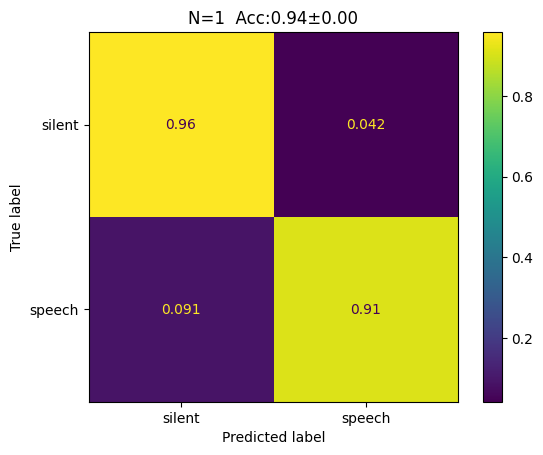

<Figure size 20000x20000 with 0 Axes>

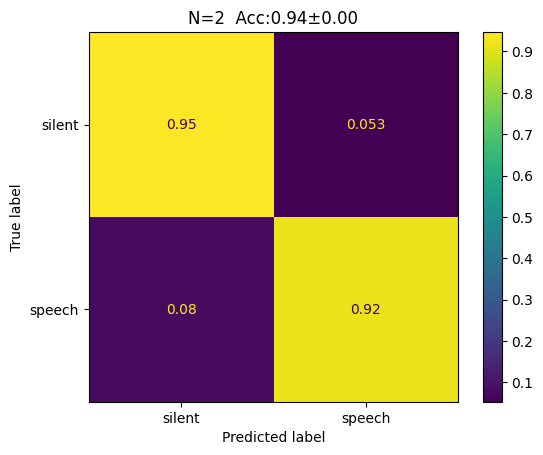

<Figure size 20000x20000 with 0 Axes>

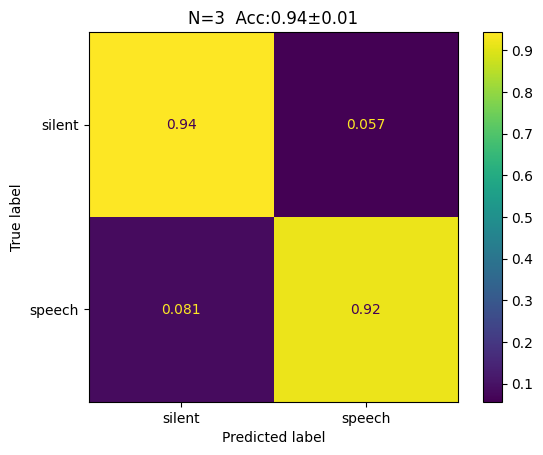

<Figure size 20000x20000 with 0 Axes>

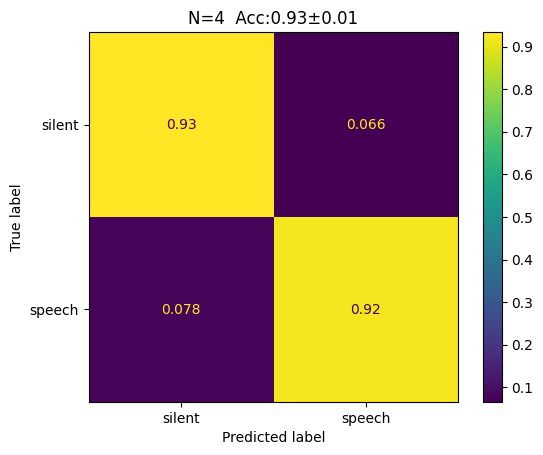

In [9]:
verbose = True
_, _, _, onset_prob = CV_val_onset(CV_datasets=CV_onset_datasets, 
                                    lr=lr, batch_size=batch_size, patience=patience, 
                                    class_weight=class_weight, val_ratio=val_ratio, 
                                    channelNum=256)

#INSPECTION: CONFUSION MATRIX FOR SPEECH DETECTOR WILL BE AUTOMATEDLY PLOTTED WHILE CROSS VALIDATION

In [ ]:
#PERFORM SALIENCY MAPPING FOR SPEECH DETECTOR
'''
verbose = False
onset_grad_list = CV_grad_onset(CV_datasets=CV_onset_datasets, 
                                    lr=lr, batch_size=batch_size, patience=patience, 
                                    class_weight=class_weight, val_ratio=val_ratio, 
                                    channelNum=256)
np.save(subject+'_onset_grad.npy',np.stack(onset_grad_list,axis=0))###
'''

In [17]:
#SAVE DATA
#np.save(subject+'_onset_prob.npy',onset_prob)###
onset_prob = np.load(subject+'_onset_prob.npy',allow_pickle=True)###
print(onset_prob.shape)

(41318, 2)


In [18]:
clipTimeMat,plot_data = slicer(interval, onset_label_mat, predicted=np.vstack(onset_prob)[:,1], sylb_mat = sylb_mat, 
                       smooth_window = 0.046,
                       smooth_threshold = 0.66,
                       onset_duration = 0.24,
                       offset_duration = 0.06,
                       word_duration = 0.5,eps = 0.1)
print(clipTimeMat)

####UNIFY MODEL WITH PREDEFINED HYPERPARAMETERS
'''
clipTimeMat,plot_data = slicer(interval, onset_label_mat, predicted=np.vstack(onset_prob)[:,1], sylb_mat = sylb_mat, 
                       smooth_window = 0.046,
                       smooth_threshold = 0.62,
                       onset_duration = 0.24,
                       offset_duration = 0.08,
                       word_duration = 0.5,eps = 0.1)
                       
#np.save(subject+'_MED_clipTimeMat.npy',clipTimeMat)###
clipTimeMat = np.load(subject+'_MED_clipTimeMat.npy',allow_pickle=True)###
print(clipTimeMat.shape)
'''

(7, 257)
(7, 257)
(7, 66) (66,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
(7, 65) (65,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. nan 14. 15. 16.
 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64.]
(7, 64) (64,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
(7, 64) (64,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
detect_onsets: 257
[[  8.        5.        4.      ...   7.        4.    

"\nclipTimeMat,plot_data = slicer(interval, onset_label_mat, predicted=np.vstack(onset_prob)[:,1], sylb_mat = sylb_mat, \n                       smooth_window = 0.046,\n                       smooth_threshold = 0.62,\n                       onset_duration = 0.24,\n                       offset_duration = 0.08,\n                       word_duration = 0.5,eps = 0.1)\n                       \n#np.save(subject+'_MED_clipTimeMat.npy',clipTimeMat)###\nclipTimeMat = np.load(subject+'_MED_clipTimeMat.npy',allow_pickle=True)###\nprint(clipTimeMat.shape)\n"

In [19]:
#SAVE DATA
#np.save(subject+'_clipTimeMat.npy',clipTimeMat)###
clipTimeMat = np.load(subject+'_clipTimeMat.npy',allow_pickle=True)###
print(clipTimeMat.shape)

(7, 257)


In [20]:
stage='sylb'
##############################################################################
sylb_back = 0.4
sylb_forward = 0.8

batch_size_sylb = 8
lr_sylb=0.0005
EPOCH=1000
patience=50

filter_time_length = 4
n_filters = 512
conv_stride=3
pool_time_length=3
pool_stride=2
filter_length=4
n_CNN_layer=3
gruDim=64
gruLayer=1
drop_out=0.3

#UNIFY MODEL WITH SHARED HYPERPARAMETERS ACORSS PATIENTS
'''
filter_time_length = 5
n_filters = 512
conv_stride=3
pool_time_length=3
pool_stride=2
filter_length=4
n_CNN_layer=3
gruDim=64
gruLayer=2
drop_out=0.5
'''
class timespatCNNRNN(nn.Module):
    def __init__(self, *, duration, typeNum, in_chans, is_timespat,
                 n_filters_time,
                 filter_time_length,
                 n_filters_spat,
                 conv_stride,
                 pool_time_length,
                 pool_stride,
                 n_filters,
                 filter_length, 
                 n_CNN_layer,
                 gruDim,
                 gruLayer,
                 drop_out):
        super().__init__()
        
        self.conv_time = nn.Conv2d(
            1,
            n_filters_time,
            (filter_time_length, 1),
            stride=1,
        )
        
        self.conv_spat = nn.Conv2d(
            n_filters_time,
            n_filters_spat,
            (1, in_chans),
            stride=(conv_stride, 1),
        )
        self.is_timespat = is_timespat
        self.conv_timespat = nn.Conv2d(
            1,
            n_filters_spat,
            (filter_time_length, in_chans),
            stride=(conv_stride, 1),
        )
        
        self.bnorm = nn.BatchNorm2d(
            n_filters_spat,
            #momentum=self.batch_norm_alpha,
            affine=True,
            eps=1e-5)
        self.elu = nn.ELU()
        self.pool = nn.MaxPool2d(kernel_size=(pool_time_length, 1), stride=(pool_stride, 1))
        
        self.conv_pool_block = nn.ModuleList()
        self.conv_pool_block.append(nn.Dropout(p=drop_out))
        self.conv_pool_block.append(nn.Conv2d(
            n_filters_spat,
            n_filters,
            (filter_length, 1),
            stride=(conv_stride, 1),
            padding=(((filter_length - 1) * conv_stride) // 2,0)
        ))
        
        for i in range(n_CNN_layer-1):
            self.conv_pool_block.append(nn.Dropout(p=drop_out))
            self.conv_pool_block.append(nn.Conv2d(
                n_filters,
                n_filters,
                (filter_length, 1),
                stride=(conv_stride, 1),
                padding=(((filter_length - 1) * conv_stride) // 2,0)
            ))
            self.conv_pool_block.append(nn.BatchNorm2d(
                n_filters,
                momentum=0.1,
                affine=True,
                eps=1e-5,
            ))
            self.conv_pool_block.append(nn.ELU())
            self.conv_pool_block.append(nn.MaxPool2d(
                kernel_size=(pool_time_length, 1),
                stride=(pool_stride, 1),
            ))

        self.gru1 = nn.GRU(n_filters, gruDim, gruLayer, batch_first=True, bidirectional=True)
        elec_feature = int(2*gruDim)
        self.fc1 = nn.Linear(elec_feature, typeNum)

    def forward(self, x):
        x = rearrange(x,'(batch 1) electrodes duration -> batch 1 duration electrodes')
        if self.is_timespat:
            x = self.conv_timespat(x)
        else:
            x = self.conv_time(x)
            #print('1',x.shape)
            x = self.conv_spat(x)
        #print('2',x.shape)
        x = self.bnorm(x)
        x = self.elu(x)
        x = self.pool(x)
        for block in self.conv_pool_block:
            x = block(x)
        x = rearrange(x,'batch filter duration 1 -> batch duration filter')
        x = self.gru1(x)[0][:,-1,:]
        #x = self.relu1(x) 
        x = self.fc1(x)
        return x

model2 = timespatCNNRNN(duration=int((sylb_back+sylb_forward)*hz), typeNum=10, in_chans=len(sylb_elecs),
                                    is_timespat=True,
                                    n_filters_time=n_filters, filter_time_length=filter_time_length,
                                    n_filters_spat=n_filters, conv_stride=conv_stride,
                                    pool_time_length=pool_time_length, pool_stride=pool_stride,
                                    n_filters=n_filters, 
                                    filter_length=filter_length, 
                                    n_CNN_layer=n_CNN_layer,
                                    gruDim=gruDim,
                                    gruLayer=gruLayer,
                                    drop_out=drop_out).to(device)
# Create a numpy array
#A = np.zeros((4, len(sylb_elecs), 480))
# Convert the numpy array to a PyTorch tensor and set its data type to float
#A_tensor = torch.from_numpy(A).float()
# Make the prediction
#output = model2(A_tensor)
#print(output.shape)

torch.save(model2,("./"+subject+'_sylb.pt'))
torch.save(model2,("./"+subject+'.pt'))
###################################################################################################
#BASELINE CNN MODEL
'''
class CNN(nn.Module):
    def __init__(self, *, duration, typeNum, in_chans, is_timespat,
                 n_filters_time,
                 filter_time_length,
                 n_filters_spat,
                 conv_stride,
                 pool_time_length,
                 pool_stride,
                 n_filters,
                 filter_length, 
                 n_CNN_layer,
                 gruDim,
                 gruLayer,
                 drop_out):
        super().__init__()
        
        self.conv_time = nn.Conv1d(
            in_chans,
            n_filters,
            filter_time_length,
            stride=1,
        )
        
        
        self.bnorm = nn.BatchNorm2d(
            n_filters,
            #momentum=self.batch_norm_alpha,
            affine=True,
            eps=1e-5)
        self.elu = nn.ELU()
        self.pool = nn.MaxPool1d(kernel_size=pool_time_length, stride=pool_stride)
        
        self.conv_pool_block = nn.ModuleList()
        self.conv_pool_block.append(nn.Dropout(p=drop_out))
        self.conv_pool_block.append(nn.Conv1d(
            n_filters,
            n_filters,
            filter_length,
            stride=conv_stride,
            padding=((filter_length - 1) * conv_stride) // 2
        ))
        
        for i in range(n_CNN_layer-1):
            self.conv_pool_block.append(nn.Dropout(p=drop_out))
            self.conv_pool_block.append(nn.Conv1d(
                n_filters,
                n_filters,
                filter_length,
                stride=conv_stride,
                padding=((filter_length - 1) * conv_stride) // 2
            ))
            self.conv_pool_block.append(nn.BatchNorm1d(
                n_filters,
                momentum=0.1,
                affine=True,
                eps=1e-5,
            ))
            self.conv_pool_block.append(nn.ELU())
            self.conv_pool_block.append(nn.MaxPool1d(
                kernel_size=pool_time_length,
                stride=pool_stride,
            ))
        featureDim = 1024
        self.fc1 = nn.Linear(featureDim, typeNum)
    def forward(self, x):
        #x = rearrange(x,'(batch 1) electrodes duration -> batch 1 duration electrodes')
        x = self.conv_time(x)
        x = self.elu(x)
        x = self.pool(x)
        for block in self.conv_pool_block:
            x = block(x)
        x = rearrange(x,'batch filter duration -> batch (filter duration)')
        #x = self.relu1(x) 
        x = self.fc1(x)
        return x
    
model2C = CNN(duration=int((sylb_back+sylb_forward)*hz), typeNum=10, in_chans=len(sylb_elecs),
                                    is_timespat=True,
                                    n_filters_time=n_filters, filter_time_length=filter_time_length,
                                    n_filters_spat=n_filters, conv_stride=conv_stride,
                                    pool_time_length=pool_time_length, pool_stride=pool_stride,
                                    n_filters=n_filters, 
                                    filter_length=filter_length, 
                                    n_CNN_layer=n_CNN_layer,
                                    gruDim=gruDim,
                                    gruLayer=gruLayer,
                                    drop_out=drop_out).to(device)


#A = np.zeros((8, len(sylb_elecs), 480))
#A_tensor = torch.from_numpy(A).float()
#output = model2C(A_tensor)
#print(output.shape)

torch.save(model2C,("./"+subject+'_CNN_sylb.pt'))
torch.save(model2C,("./"+subject+'.pt'))

###################################################################################################
'''
#BASELINE RNN MODEL
'''
class RNN(nn.Module):
    def __init__(self, *, duration, typeNum, in_chans, is_timespat,
                 n_filters_time,
                 filter_time_length,
                 n_filters_spat,
                 conv_stride,
                 pool_time_length,
                 pool_stride,
                 n_filters,
                 filter_length, 
                 n_CNN_layer,
                 gruDim,
                 gruLayer,
                 drop_out):
        super().__init__()
        
        self.gru1 = nn.GRU(in_chans, gruDim, gruLayer, batch_first=True, bidirectional=True)
        elec_feature = int(2*gruDim)
        self.fc1 = nn.Linear(elec_feature, typeNum)

    def forward(self, x):
        x = rearrange(x,'batch filter duration -> batch duration filter')
        x = self.gru1(x)[0][:,-1,:]
        x = self.fc1(x)
        return x

model2R = RNN(duration=int((sylb_back+sylb_forward)*hz), typeNum=10, in_chans=len(sylb_elecs),
                                    is_timespat=True,
                                    n_filters_time=n_filters, filter_time_length=filter_time_length,
                                    n_filters_spat=n_filters, conv_stride=conv_stride,
                                    pool_time_length=pool_time_length, pool_stride=pool_stride,
                                    n_filters=n_filters, 
                                    filter_length=filter_length, 
                                    n_CNN_layer=n_CNN_layer,
                                    gruDim=gruDim,
                                    gruLayer=gruLayer,
                                    drop_out=drop_out).to(device)

# Create a numpy array
#A = np.zeros((8, len(sylb_elecs), 480))
# Convert the numpy array to a PyTorch tensor and set its data type to float
#A_tensor = torch.from_numpy(A).float()
# Make the prediction
#output = model2R(A_tensor)
#print(output.shape)

torch.save(model2R,("./"+subject+'_RNN_sylb.pt'))
torch.save(model2R,("./"+subject+'.pt'))

###################################################################################################
'''

'\nclass RNN(nn.Module):\n    def __init__(self, *, duration, typeNum, in_chans, is_timespat,\n                 n_filters_time,\n                 filter_time_length,\n                 n_filters_spat,\n                 conv_stride,\n                 pool_time_length,\n                 pool_stride,\n                 n_filters,\n                 filter_length, \n                 n_CNN_layer,\n                 gruDim,\n                 gruLayer,\n                 drop_out):\n        super().__init__()\n        \n        self.gru1 = nn.GRU(in_chans, gruDim, gruLayer, batch_first=True, bidirectional=True)\n        elec_feature = int(2*gruDim)\n        self.fc1 = nn.Linear(elec_feature, typeNum)\n\n    def forward(self, x):\n        x = rearrange(x,\'batch filter duration -> batch duration filter\')\n        x = self.gru1(x)[0][:,-1,:]\n        x = self.fc1(x)\n        return x\n\nmodel2R = RNN(duration=int((sylb_back+sylb_forward)*hz), typeNum=10, in_chans=len(sylb_elecs),\n                 

In [21]:
CV_sylb_datasets,_,_ = CV_val_datasets(back=sylb_back,
                            forward=sylb_forward,
                            mat=sylb_mat,
                            key_elecs=sylb_elecs,
                            row=0,
                            CV_list=[[1,5,9],[2,6,10],[3,7,11],[4,8,12],[13,],[14,],[15,],[16,]],
                            unbalance=False,List=False,
                            augmented=False)

CV_sylb_clip_datasets,_,_ = CV_val_datasets(back=sylb_back,
                            forward=sylb_forward,
                            mat=clipTimeMat,
                            key_elecs=sylb_elecs,
                            row=0,
                            CV_list=[[13,],[14,],[15,],[16,]],
                            unbalance=False,List=False,
                            augmented=False)


mat: (7, 1034)
select paraqraph:[1, 5, 9] select elecs:[  0   1   2   5   8   9  13  14  15  32  46  48  49  59  64  95  96 100
 110 111 112 126 128 135 136 137 138 139 140 142 143 150 151 152 153 154
 155 156 157 158 159 166 167 168 169 170 171 172 173 174 175 180 181 182
 183 184 185 186 187 188 189 190 191 197 199 201 204 214 215 226 231 242
 243 253 254] read_ecog: (192, 75, 480)
mat: (7, 1034)
select paraqraph:[2, 6, 10] select elecs:[  0   1   2   5   8   9  13  14  15  32  46  48  49  59  64  95  96 100
 110 111 112 126 128 135 136 137 138 139 140 142 143 150 151 152 153 154
 155 156 157 158 159 166 167 168 169 170 171 172 173 174 175 180 181 182
 183 184 185 186 187 188 189 190 191 197 199 201 204 214 215 226 231 242
 243 253 254] read_ecog: (190, 75, 480)
mat: (7, 1034)
select paraqraph:[3, 7, 11] select elecs:[  0   1   2   5   8   9  13  14  15  32  46  48  49  59  64  95  96 100
 110 111 112 126 128 135 136 137 138 139 140 142 143 150 151 152 153 154
 155 156 157 158 159 16

In [ ]:
verbose=False
plot=False

_,_,_,sylb_test_out_prob_list,_,sylb_pred_only_prob_list = CV_val_ENN(
                               CV_datasets = CV_sylb_datasets, 
                               CV_pred_only_datasets = CV_sylb_clip_datasets,
                               lr=lr_sylb, batch_size=batch_size_sylb, patience=patience,
                               class_weight = False, channelNum=256)


In [22]:
#PERFORM SALIENCY MAPPING FOR SYLLABLE DECOEDER
'''
verbose=False
plot=False
sylb_grad_list = CV_grad_ENN(fullname=fullname, 
                               CV_datasets = CV_sylb_datasets, 
                               CV_pred_only_datasets = CV_sylb_datasets, 
                               lr=lr_sylb, batch_size=batch_size_sylb, patience=patience,
                               class_weight = False, channelNum=256)
np.save(subject+'_sylb_grad.npy',np.stack(sylb_grad_list,axis=0))###
'''

"\nverbose=False\nplot=False\nsylb_grad_list = CV_grad_ENN(fullname=fullname, \n                               CV_datasets = CV_sylb_datasets, \n                               CV_pred_only_datasets = CV_sylb_datasets, \n                               lr=lr_sylb, batch_size=batch_size_sylb, patience=patience,\n                               class_weight = False, channelNum=256)\nnp.save(subject+'_sylb_grad.npy',np.stack(sylb_grad_list,axis=0))###\n"

In [23]:
#SAVE DATA
#np.save(subject+'_sylb_pred.npy',np.array([sylb_test_out_prob_list, sylb_pred_only_prob_list]))###
sylb_test_out_prob_list, sylb_pred_only_prob_list = np.load(subject+'_sylb_pred.npy',allow_pickle=True)###

[[0.54166667 0.         0.04166667 0.         0.         0.04166667
  0.04166667 0.         0.         0.33333333]
 [0.04347826 0.82608696 0.         0.         0.         0.
  0.         0.08695652 0.04347826 0.        ]
 [0.1        0.03333333 0.3        0.         0.         0.1
  0.23333333 0.         0.         0.23333333]
 [0.         0.         0.         0.95833333 0.         0.
  0.         0.         0.         0.04166667]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.95833333
  0.         0.04166667 0.         0.        ]
 [0.07142857 0.         0.14285714 0.         0.         0.
  0.71428571 0.         0.         0.07142857]
 [0.         0.         0.04347826 0.04347826 0.         0.04347826
  0.         0.69565217 0.04347826 0.13043478]
 [0.         0.03571429 0.         0.         0.         0.
  0.         0.07142857 0.85714286 0.03571429]
 [0.07407407

([0.65625, 0.6875, 0.6875, 0.71875],
 [tensor(0.0293), tensor(0.0285), tensor(0.0292), tensor(0.0290)])

<Figure size 20000x20000 with 0 Axes>

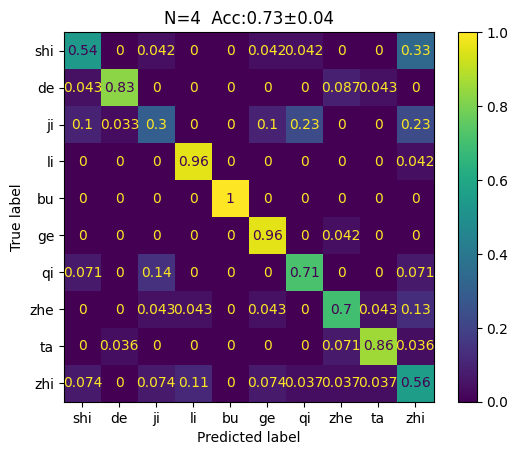

<Figure size 20000x20000 with 0 Axes>

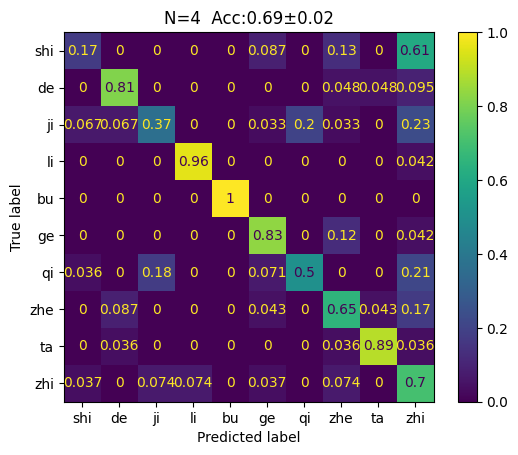

In [24]:
#INSPECTION: PLOT CONFUSION MATRIX FOR SYLLABLE DECODER
plot = True
stage = 'sylb'
evaluater(sylb_label_mat, sylb_test_out_prob_list, loss_func = nn.CrossEntropyLoss(), unit = 3)

stage = 'onset_sylb'
evaluater(clipTimeMat, sylb_pred_only_prob_list, loss_func = nn.CrossEntropyLoss(), unit = 3)

In [25]:
stage= 'tone'
plot = False

tone_back = 0.2
tone_forward = 0.6

In [26]:
batch_size_tone = 8
lr_tone=0.001
EPOCH=1000
patience=50
#OPTIMIZED HYPERPARAMETERS
filter_time_length = 2
n_filters = 64
conv_stride=3
pool_time_length=3
pool_stride=3
filter_length=2
n_CNN_layer=1
gruDim=128
gruLayer=1
drop_out=0.8

#UNIFY MODEL WITH SHARED HYPERPARAMETERS ACORSS PATIENTS
'''
filter_time_length = 2
n_filters = 64
conv_stride=3
pool_time_length=3
pool_stride=3
filter_length=3
n_CNN_layer=2
gruDim=128
gruLayer=2
drop_out=0.7
'''

model3 = timespatCNNRNN(duration=int((tone_back+tone_forward)*hz), typeNum=4, in_chans=len(tone_elecs),
                                    is_timespat=True,
                                    n_filters_time=n_filters, filter_time_length=filter_time_length,
                                    n_filters_spat=n_filters, conv_stride=conv_stride,
                                    pool_time_length=pool_time_length, pool_stride=pool_stride,
                                    n_filters=n_filters, 
                                    filter_length=filter_length, 
                                    n_CNN_layer=n_CNN_layer,
                                    gruDim=gruDim,
                                    gruLayer=gruLayer,
                                    drop_out=drop_out).to(device)

torch.save(model3,("./"+subject+'_tone.pt'))
torch.save(model3,("./"+subject+'.pt'))
#########################################################################################
#BASELINE CNN MODEL 
'''
class CNN(nn.Module):############for tone
    def __init__(self, *, duration, typeNum, in_chans, is_timespat,
                 n_filters_time,
                 filter_time_length,
                 n_filters_spat,
                 conv_stride,
                 pool_time_length,
                 pool_stride,
                 n_filters,
                 filter_length, 
                 n_CNN_layer,
                 gruDim,
                 gruLayer,
                 drop_out):
        super().__init__()
        
        self.conv_time = nn.Conv1d(
            in_chans,
            n_filters,
            filter_time_length,
            stride=1,
        )
        
        
        self.bnorm = nn.BatchNorm2d(
            n_filters,
            #momentum=self.batch_norm_alpha,
            affine=True,
            eps=1e-5)
        self.elu = nn.ELU()
        self.pool = nn.MaxPool1d(kernel_size=pool_time_length, stride=pool_stride)
        
        self.conv_pool_block = nn.ModuleList()
        self.conv_pool_block.append(nn.Dropout(p=drop_out))
        self.conv_pool_block.append(nn.Conv1d(
            n_filters,
            n_filters,
            filter_length,
            stride=conv_stride,
            padding=((filter_length - 1) * conv_stride) // 2
        ))
        
        for i in range(n_CNN_layer-1):
            self.conv_pool_block.append(nn.Dropout(p=drop_out))
            self.conv_pool_block.append(nn.Conv1d(
                n_filters,
                n_filters,
                filter_length,
                stride=conv_stride,
                padding=((filter_length - 1) * conv_stride) // 2
            ))
            self.conv_pool_block.append(nn.BatchNorm1d(
                n_filters,
                momentum=0.1,
                affine=True,
                eps=1e-5,
            ))
            self.conv_pool_block.append(nn.ELU())
            self.conv_pool_block.append(nn.MaxPool1d(
                kernel_size=pool_time_length,
                stride=pool_stride,
            ))
        featureDim = 1152
        self.fc1 = nn.Linear(featureDim, typeNum)

    def forward(self, x):
        #x = rearrange(x,'(batch 1) electrodes duration -> batch 1 duration electrodes')
        x = self.conv_time(x)
        x = self.elu(x)
        x = self.pool(x)
        for block in self.conv_pool_block:
            x = block(x)
        x = rearrange(x,'batch filter duration -> batch (filter duration)')
        #x = self.relu1(x) 
        x = self.fc1(x)
        return x

model3C = CNN(duration=int((tone_back+tone_forward)*hz), typeNum=4, in_chans=len(tone_elecs),
                                    is_timespat=True,
                                    n_filters_time=n_filters, filter_time_length=filter_time_length,
                                    n_filters_spat=n_filters, conv_stride=conv_stride,
                                    pool_time_length=pool_time_length, pool_stride=pool_stride,
                                    n_filters=n_filters, 
                                    filter_length=filter_length, 
                                    n_CNN_layer=n_CNN_layer,
                                    gruDim=gruDim,
                                    gruLayer=gruLayer,
                                    drop_out=drop_out)#.to(device)

# Create a numpy array
A = np.zeros((4, len(tone_elecs), 320))
# Convert the numpy array to a PyTorch tensor and set its data type to float
A_tensor = torch.from_numpy(A).float()
# Make the prediction
output = model3C(A_tensor)
print(output.shape)

torch.save(model3C,("./"+subject+'_CNN_tone.pt'))
torch.save(model3C,("./"+subject+'.pt'))
'''
#BASELINE RNN MODEL
'''
###################################################################################################
model3R = RNN(duration=int((tone_back+tone_forward)*hz), typeNum=4, in_chans=len(tone_elecs),
                                    is_timespat=True,
                                    n_filters_time=n_filters, filter_time_length=filter_time_length,
                                    n_filters_spat=n_filters, conv_stride=conv_stride,
                                    pool_time_length=pool_time_length, pool_stride=pool_stride,
                                    n_filters=n_filters, 
                                    filter_length=filter_length, 
                                    n_CNN_layer=n_CNN_layer,
                                    gruDim=gruDim,
                                    gruLayer=gruLayer,
                                    drop_out=drop_out).to(device)

# Create a numpy array
#A = np.zeros((8, len(sylb_elecs), 320))
# Convert the numpy array to a PyTorch tensor and set its data type to float
#A_tensor = torch.from_numpy(A).float()
# Make the prediction
#output = model3R(A_tensor)
#print(output.shape)
torch.save(model3R,("./"+subject+'_RNN_tone.pt'))
torch.save(model3R,("./"+subject+'.pt'))
'''
#BASELINE MONOSYLLABIC MODEL
'''
class RES(nn.Module):
    def __init__(self, tonal_channel_num):
        super(RES, self).__init__()
        self.maxpool0 = nn.MaxPool2d(kernel_size=(1, 4), stride=None, padding=0)
        self.lstm1 = nn.LSTM(tonal_channel_num, 320, batch_first=True)
        self.conv1 = nn.Conv2d(1, 1024, kernel_size=(7, 1), stride=1, padding=0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=None, padding=0)
        self.conv2 = nn.Conv2d(1, 1024, kernel_size=(7, 1), stride=1, padding=0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1), stride=None, padding=0)
        #self.concat = nn.Concatenate(dim=2)
        self.conv3 = nn.Conv2d(1024, 512, kernel_size=(7, 1), stride=1, padding=0)
        self.conv4 = nn.Conv2d(512, 256, kernel_size=(7, 1), stride=1, padding=0)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 1), stride=None, padding=0)
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(512, 4)
        self.lstm2 = nn.LSTM(13312, 512, batch_first=True)
        self.output_layer = nn.Linear(512, 4)
        
    def forward(self, inputs_TG):
        inputs_TG = self.maxpool0(inputs_TG)
        x = rearrange(inputs_TG,'batch electrodes duration -> batch 1  duration electrodes')#inputs_TG
        x = self.conv1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.maxpool1(x)
        
        x1 = rearrange(inputs_TG,'batch electrodes duration -> batch duration electrodes')
        x1, _ = self.lstm1(x1)
        x1 = x1[:, -1, :] 

        duration = 80
        add_dim = 4
        x1 = x1.reshape(-1,duration,add_dim)
        x1 = rearrange(x1,'batch duration add_dim -> batch 1 duration add_dim')#inputs_TG
        x1 = self.conv2(x1)
        x1 = F.leaky_relu(x1, negative_slope=0.01)
        x1 = self.maxpool2(x1)
        
        xf = torch.cat((x1, x), dim=3)
        x = self.conv3(xf)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.conv4(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.maxpool3(x)
        x = self.dropout(x)
        x = rearrange(x,'batch electrodes duration width -> batch duration (electrodes width)')#(electrodes width)
        #print(x.shape[2])
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Take the last LSTM output
        #print(x.shape)
        x = self.dense1(x)
        return x

model3E = RES(len(tone_elecs)).to(device)

# TEST THE MODEL ON CPU
#A = np.zeros((8, len(tone_elecs), 320))
#A_tensor = torch.from_numpy(A).float()
#output = model3E(A_tensor)
#print(output.shape)

torch.save(model3E,("./"+subject+'_RES_tone.pt'))
torch.save(model3E,("./"+subject+'.pt'))
'''

'\nclass RES(nn.Module):\n    def __init__(self, tonal_channel_num):\n        super(RES, self).__init__()\n        self.maxpool0 = nn.MaxPool2d(kernel_size=(1, 4), stride=None, padding=0)\n        self.lstm1 = nn.LSTM(tonal_channel_num, 320, batch_first=True)\n        self.conv1 = nn.Conv2d(1, 1024, kernel_size=(7, 1), stride=1, padding=0)\n        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 1), stride=None, padding=0)\n        self.conv2 = nn.Conv2d(1, 1024, kernel_size=(7, 1), stride=1, padding=0)\n        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 1), stride=None, padding=0)\n        #self.concat = nn.Concatenate(dim=2)\n        self.conv3 = nn.Conv2d(1024, 512, kernel_size=(7, 1), stride=1, padding=0)\n        self.conv4 = nn.Conv2d(512, 256, kernel_size=(7, 1), stride=1, padding=0)\n        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 1), stride=None, padding=0)\n        self.dropout = nn.Dropout(0.5)\n        self.dense1 = nn.Linear(512, 4)\n        self.lstm2 = nn.LSTM(13312,

In [27]:
CV_tone_datasets,count_total,_ = CV_val_datasets(back=tone_back,
                            forward=tone_forward,
                            mat=sylb_mat,
                            key_elecs=tone_elecs,
                            row=5,
                            CV_list=[[1,5,9],[2,6,10],[3,7,11],[4,8,12],[13,],[14,],[15,],[16,]],
                            unbalance=True,List=toneList,
                            augmented=False)

class_weight = np.sum(count_total,axis=0)

CV_tone_clip_datasets,_,_ = CV_val_datasets(back=tone_back,
                            forward=tone_forward,
                            mat=clipTimeMat,
                            key_elecs=tone_elecs,
                            row=0,
                            CV_list=[[13,],[14,],[15,],[16,]],
                            unbalance=False,List=False,
                            augmented=False)

mat: (7, 1034)
select paraqraph:[1, 5, 9] select elecs:[  0   1   2   5   8   9  13  14  15  32  46  48  59  75  78  95  96 100
 110 111 112 136 137 151 152 156 166 167 168 171 172 174 181 183 188 189
 197 198 199 204 211 214 226 228 230 242 253 254] read_ecog: (192, 48, 320)
[64 38 24 66]
mat: (7, 1034)
select paraqraph:[2, 6, 10] select elecs:[  0   1   2   5   8   9  13  14  15  32  46  48  59  75  78  95  96 100
 110 111 112 136 137 151 152 156 166 167 168 171 172 174 181 183 188 189
 197 198 199 204 211 214 226 228 230 242 253 254] read_ecog: (190, 48, 320)
[63 45 23 59]
mat: (7, 1034)
select paraqraph:[3, 7, 11] select elecs:[  0   1   2   5   8   9  13  14  15  32  46  48  59  75  78  95  96 100
 110 111 112 136 137 151 152 156 166 167 168 171 172 174 181 183 188 189
 197 198 199 204 211 214 226 228 230 242 253 254] read_ecog: (198, 48, 320)
[67 41 24 66]
mat: (7, 1034)
select paraqraph:[4, 8, 12] select elecs:[  0   1   2   5   8   9  13  14  15  32  46  48  59  75  78  95  96 

In [ ]:
#TRAIN AND VALIDATE TONE DECODER
verbose = False
_,_,_,tone_test_out_prob_list,_,tone_pred_only_prob_list = CV_val_ENN( 
                               CV_datasets = CV_tone_datasets, 
                               CV_pred_only_datasets = CV_tone_clip_datasets,
                               lr=lr_tone, batch_size=batch_size_tone, patience=patience,
                               class_weight = class_weight, channelNum=256)


In [28]:
#TRAIN AND VALIDATE MONOSYLLABLIC MODEL
'''
verbose = True
_, _, _, tone_test_out_prob_list,tone_pred_only_prob_list = CV_val_RES(CV_datasets=CV_tone_datasets, 
                                   CV_pred_only_datasets = CV_tone_clip_datasets,
                                    lr=lr_tone, batch_size=batch_size_tone, patience=patience,
                                    class_weight=class_weight, val_ratio=val_ratio, 
                                    channelNum=256)
'''

'\nverbose = True\n_, _, _, tone_test_out_prob_list,tone_pred_only_prob_list = CV_val_RES(CV_datasets=CV_tone_datasets, \n                                   CV_pred_only_datasets = CV_tone_clip_datasets,\n                                    lr=lr_tone, batch_size=batch_size_tone, patience=patience,\n                                    class_weight=class_weight, val_ratio=val_ratio, \n                                    channelNum=256)\n'

In [29]:
#PERFORM SALIENCY MAPPING FOR TONE DECOEDER
'''
verbose=False
plot=False
tone_grad_list = CV_grad_ENN(fullname=fullname, 
                               CV_datasets = CV_tone_datasets, 
                               CV_pred_only_datasets = CV_tone_datasets, 
                               lr=lr_tone, batch_size=batch_size_tone, patience=patience,
                               class_weight = class_weight, channelNum=256)

np.save(subject+'_tone_grad.npy',np.stack(tone_grad_list,axis=0))###
'''

"\nverbose=False\nplot=False\ntone_grad_list = CV_grad_ENN(fullname=fullname, \n                               CV_datasets = CV_tone_datasets, \n                               CV_pred_only_datasets = CV_tone_datasets, \n                               lr=lr_tone, batch_size=batch_size_tone, patience=patience,\n                               class_weight = class_weight, channelNum=256)\n\nnp.save(subject+'_tone_grad.npy',np.stack(tone_grad_list,axis=0))###\n"

In [30]:
#SAVE DATA
#np.save(subject+'_tone_pred.npy',np.array([tone_test_out_prob_list,tone_pred_only_prob_list]))###
#SAVE MONOSYLLABLIC MODEL DATA
#np.save(subject+'_RES_tone_pred.npy',np.array([tone_test_out_prob_list,tone_pred_only_prob_list]))###
tone_test_out_prob_list,tone_pred_only_prob_list = np.load(subject+'_tone_pred.npy',allow_pickle=True)###

[[0.78313253 0.12048193 0.07228916 0.02409639]
 [0.09803922 0.7254902  0.09803922 0.07843137]
 [0.         0.06451613 0.87096774 0.06451613]
 [0.14893617 0.07446809 0.15957447 0.61702128]]
[[0.81707317 0.07317073 0.07317073 0.03658537]
 [0.14285714 0.73469388 0.06122449 0.06122449]
 [0.03225806 0.09677419 0.80645161 0.06451613]
 [0.17021277 0.09574468 0.12765957 0.60638298]]


([0.765625, 0.671875, 0.734375, 0.71875],
 [tensor(0.0169), tensor(0.0182), tensor(0.0166), tensor(0.0164)])

<Figure size 20000x20000 with 0 Axes>

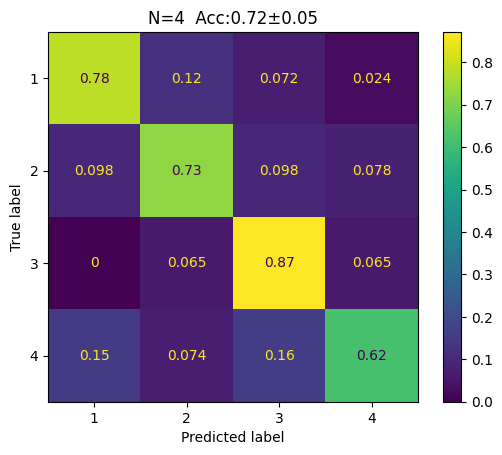

<Figure size 20000x20000 with 0 Axes>

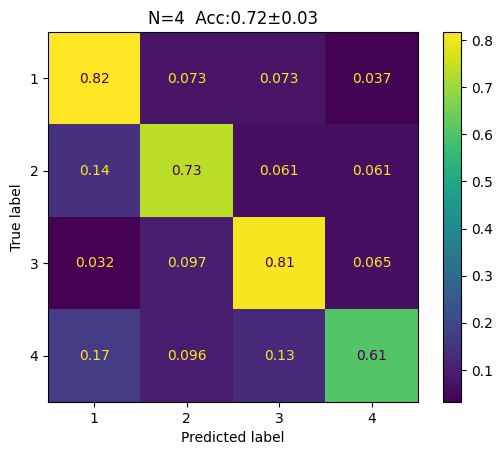

In [32]:
#INSPECTION: PLOT CONFUSION MATRIX FOR TONE DECODER
plot = True
stage = 'tone'
evaluater(sylb_label_mat, tone_test_out_prob_list, loss_func = nn.CrossEntropyLoss(), unit = 3)

stage = 'onset_tone'
evaluater(clipTimeMat, tone_pred_only_prob_list, loss_func = nn.CrossEntropyLoss(), unit = 3)

sylbTone_list: 257


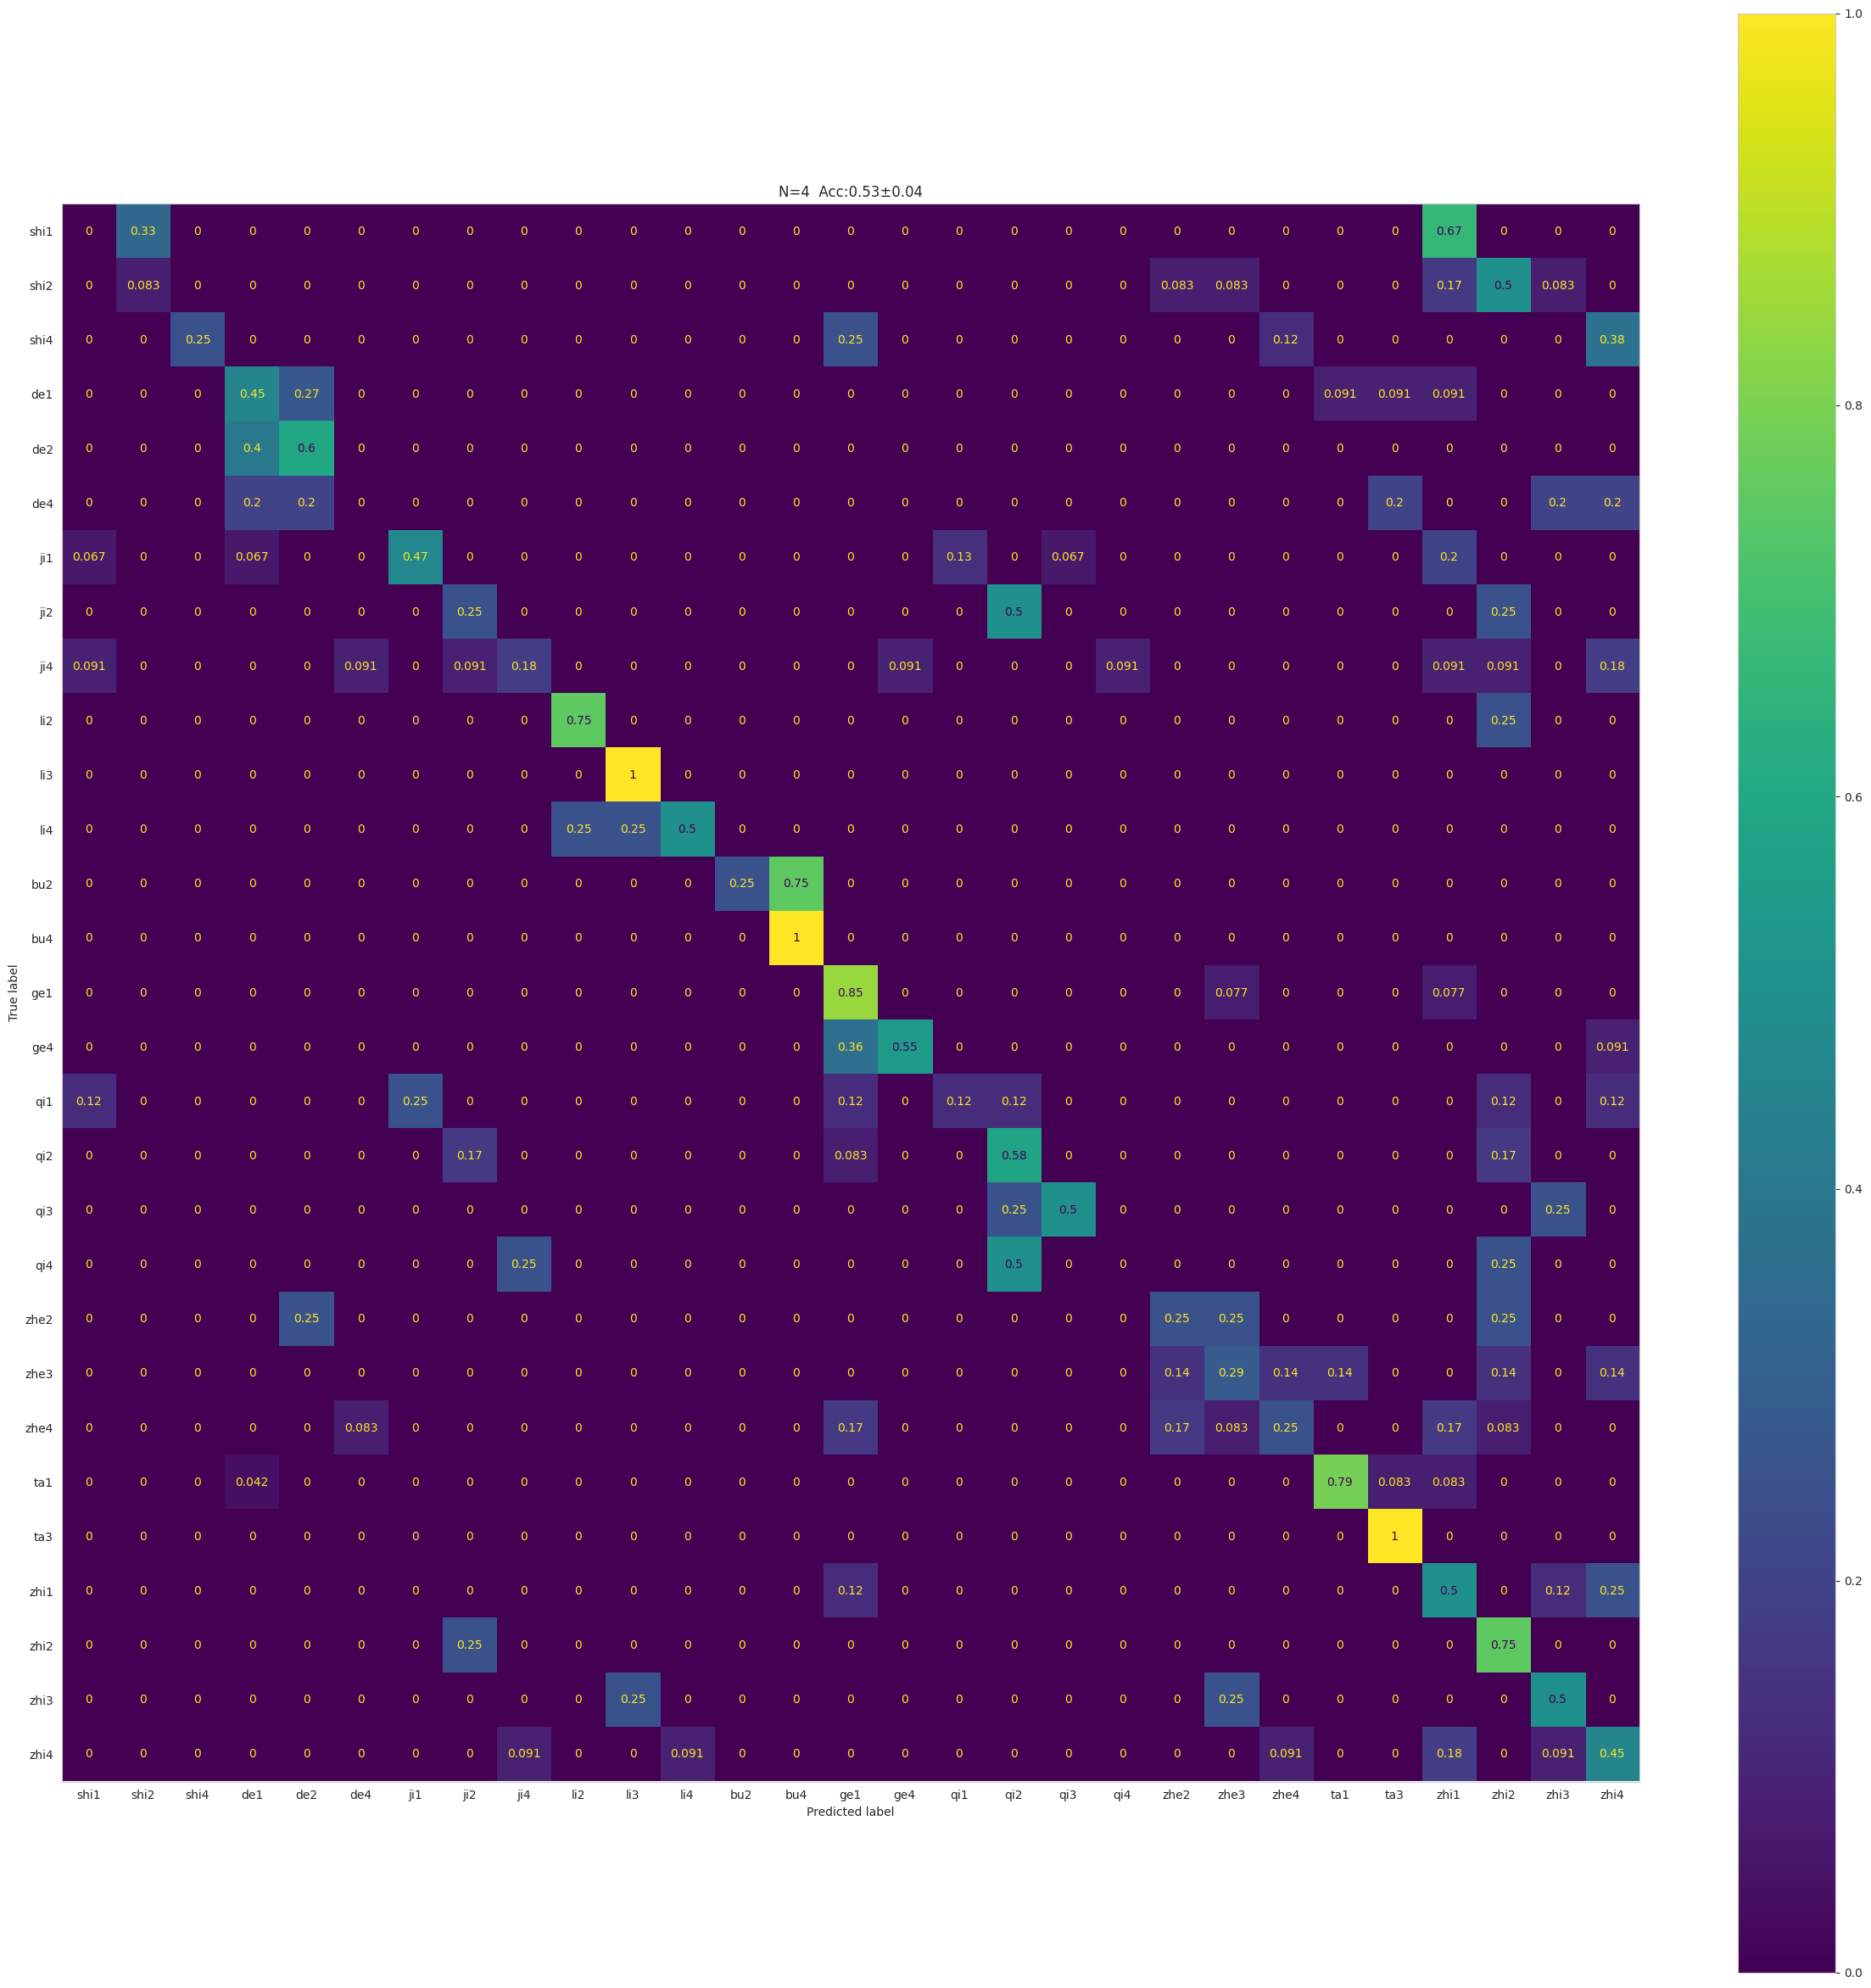

sylbTone_list: 259


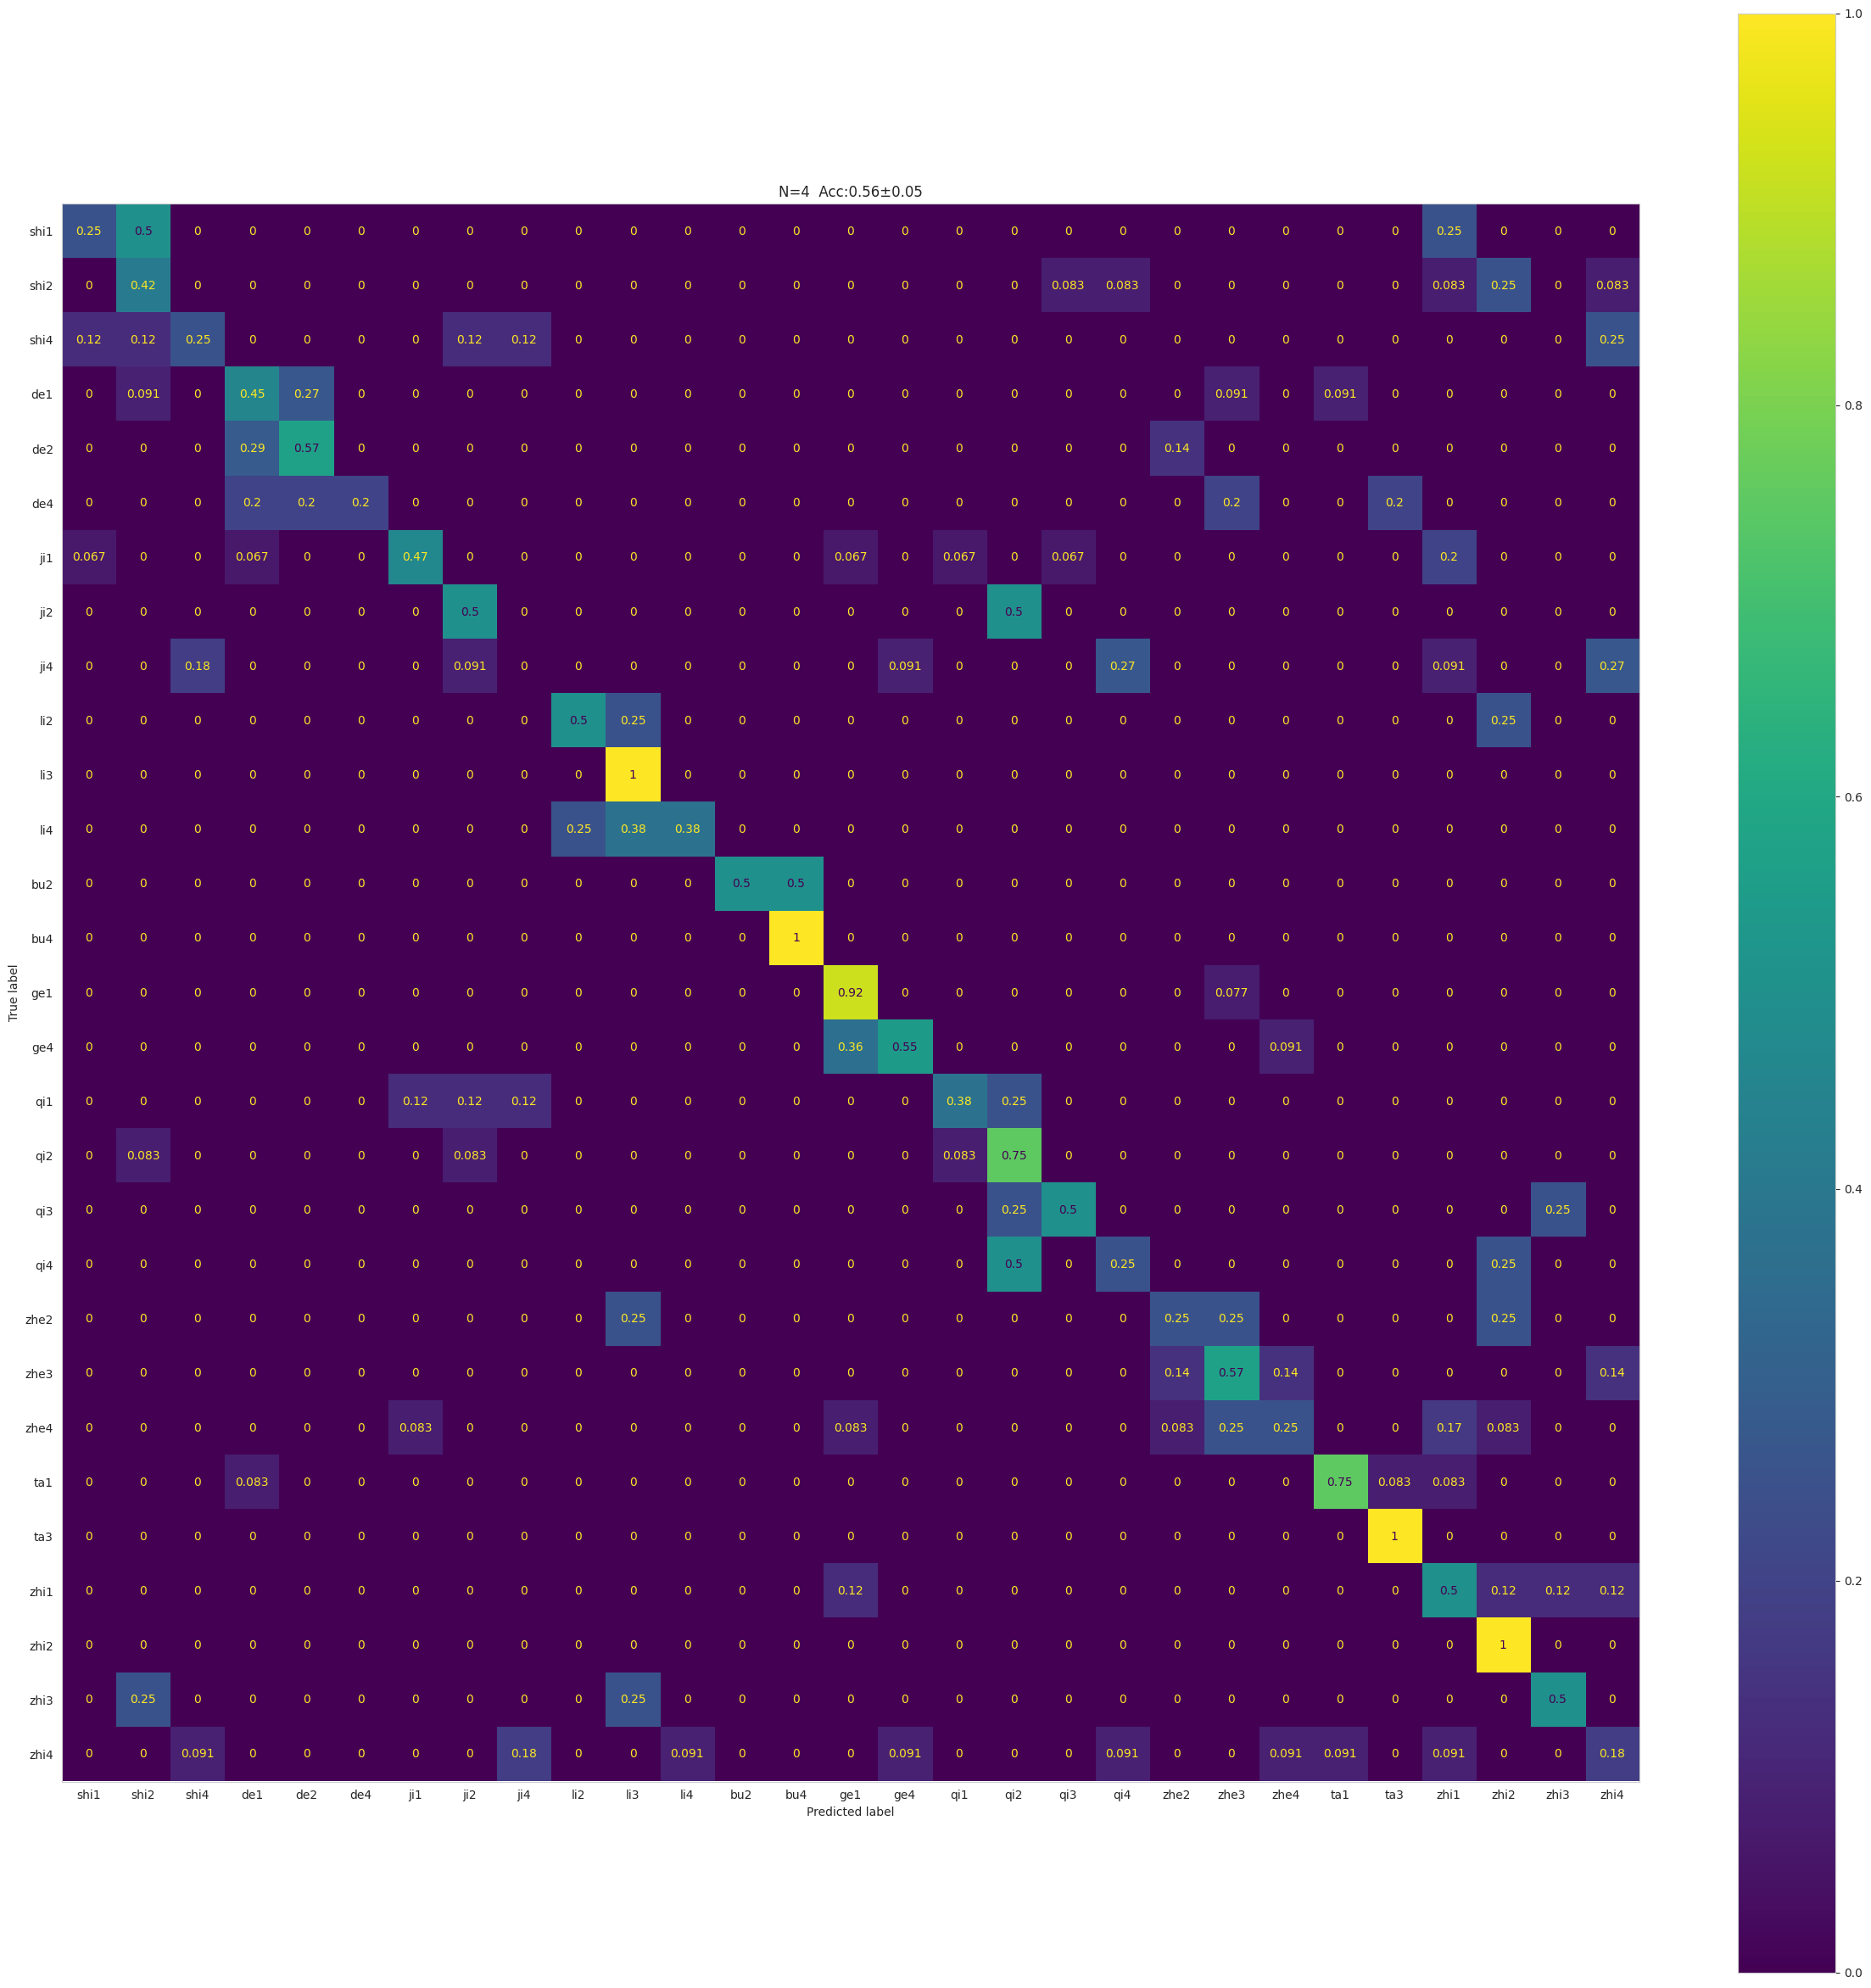

([0.5606060606060606, 0.47692307692307695, 0.609375, 0.59375],
 [16.0, 13.0, 14.0, 15.0])

In [33]:
stage = 'onset_sylb_tone'
sylb_tone_out, pred_prob_char = sylbTone2char(np.array(sylb_pred_only_prob_list).T,
                                          np.array(tone_pred_only_prob_list).T)
#INSPECTION
evaluater2(clipTimeMat, sylb_tone_out, unit=3)

stage = 'sylb_tone'
fix_sylb_tone_out, fix_pred_prob_char = sylbTone2char(np.array(sylb_test_out_prob_list).T,
                                          np.array(tone_test_out_prob_list).T)
#INSPECTION
evaluater2(sylb_label_mat, fix_sylb_tone_out, unit=3)

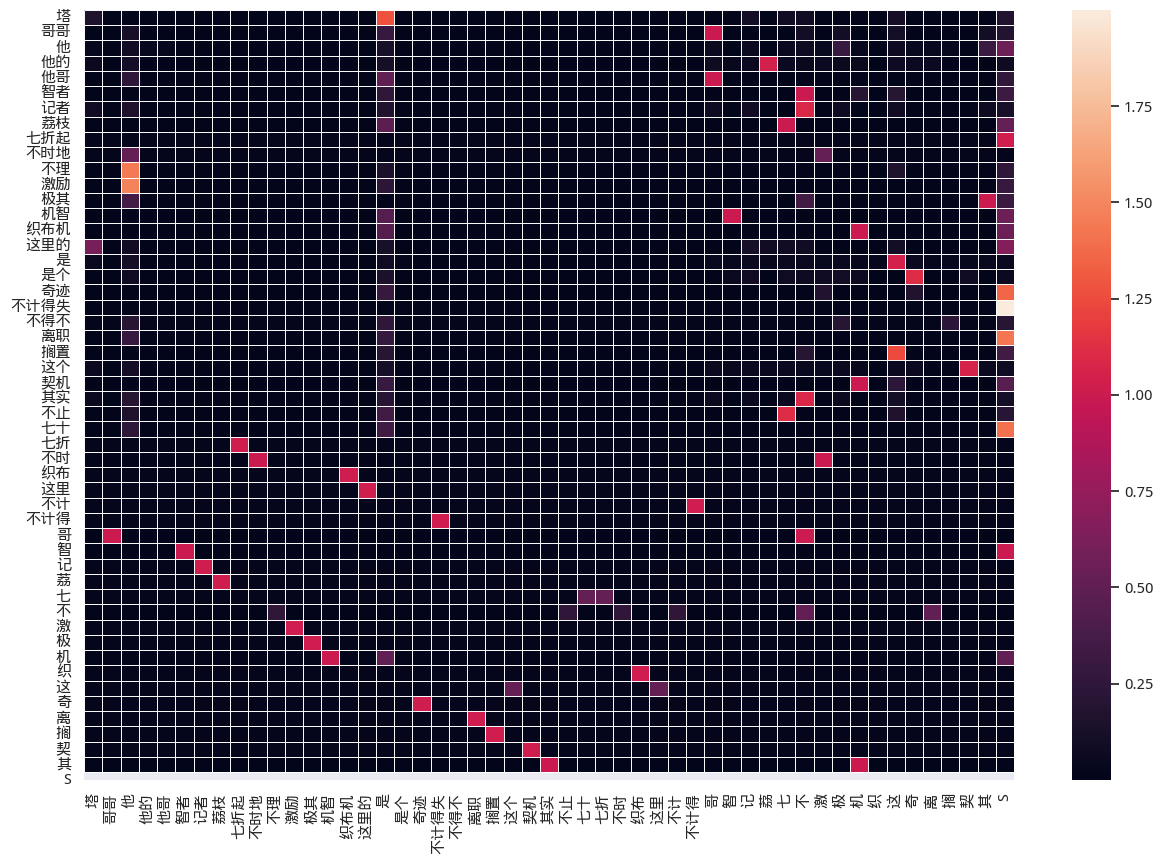

In [35]:
#GENERATE THE LANGUAGE MODEL
alpha = 1
L_index = 1.8
T_matrix = pd.read_csv(open('transfers_matrix.csv', "rb"), delimiter=',')

T_matrix = T_matrix.values
#T_matrix[range(50),range(50)]=0
T_matrix += 1e-7
T_matrix = T_matrix / T_matrix.sum(axis=1)[:, None]
#T_matrix[:,16] = 1e-7
#T_matrix[14,16] = 0.5
#T_matrix[0,16] = 0.5
#T_matrix[25,5]
#print_T_matrix(T_matrix)

#ADD TRANSFERS IN OUR TASK CORPUS INTO EXTERNAL TRANSFERS_MATRIX.CSV WHICH COLLECTED ON CCL DATABASE
T_ours = np.ones([50, 51])*1e-7
hindden_list = ['塔', '哥哥', '他', '他的', '他哥', '智者', '记者', '荔枝', '七折起', '不时地',
                '不理', '激励', '极其', '机智', '织布机', '这里的', '是', '是个', '奇迹', '不计得失',
                '不得不', '离职', '搁置', '这个', '契机', '其实', '不止', '七十', '七折', '不时',
                '织布', '这里', '不计', '不计得', '哥', '智', '记', '荔', '七', '不',
                '激', '极', '机', '织', '这', '奇', '离', '搁', '契', '其', 'S']

sentence_list = ["他哥不理他","他的荔枝七折起","哥哥不时激励他","他极其机智","织布机是这里的","这里的塔是个奇迹","智者不计得失","记者不得不离职","搁置这个契机","他其实不止七十"]
for sentence in sentence_list:
    word = sentence2word(sentence)
    write2martix(word,'S')
    
# INSPECTION OF THE TRANSFERS MATRIX FOR FINAL LANGUAGE MODEL
T_ours = T_ours / T_ours.sum(axis=1)[:, None]
print_T_matrix(T_matrix+alpha*T_ours)


class HMM():
    def __init__(self,wordofsentence,h):
        self.emission_list = ['失', '十', '时', '实', '是', '的', '地', '得', '机', '激',
            '极', '记', '计', '迹', '离', '里', '理', '励', '荔', '不',
            '布', '哥', '搁', '个', '七', '奇', '其', '起', '契', '折',
            '者', '这', '他', '塔', '织', '枝', '职', '止', '置', '智', 'S']
        self.hindden_list = ['塔','哥哥','他','他的','他哥','智者','记者','荔枝','七折起','不时地',
                '不理','激励','极其','机智','织布机','这里的','是','是个','奇迹','不计得失',
                '不得不','离职','搁置','这个','契机','其实','不止','七十','七折','不时',
                '织布','这里','不计','不计得','哥','智','记','荔','七','不',
                '激','极','机','织','这','奇','离','搁','契','其','S']
        self.start_list = ['失', '十', '时', '实', '是', '的', '地', '得', '机', '激',
            '极', '记', '计', '迹', '离', '里', '理', '励', '荔', '不',
            '布', '哥', '搁', '个', '七', '奇', '其', '起', '契', '折',
            '者', '这', '他', '塔', '织', '枝', '职', '止', '置', '智', ]
        #['哥','智','记','荔','七','不','激','极','机','织','这','奇','离','搁','契','其']
        #["他","哥","织","这","智","记","搁"]
        self.transition = T_matrix+alpha*T_ours

        self.word_prob = np.zeros([len(wordofsentence), len(self.emission_list)])
        self.word_prob[:,:len(self.emission_list)-1] = wordofsentence
        end = np.ones(41) * 1e-7
        end[-1] = 1
        self.word_prob = np.vstack([self.word_prob, end])
        self.hindden_num = len(self.hindden_list)
        self.word_length = len(self.word_prob)
        self.node_pi = -1e07*np.ones([self.word_length, self.hindden_num])
        for j in range(self.hindden_num-1):
            if self.hindden_list[j] in self.start_list:
                self.node_pi[0][j] = np.log(self.transition_hind_c(0, j))
        self.node_selection = np.zeros([self.word_length, self.hindden_num])
        self.L_scale = h
        self.word_selection_list_hindden = []
        self.word_selection_list = []
        self.word_selection_list_index = []

    def forward(self):
        for i in range(1,self.word_length):
            for j in range(self.hindden_num):
                self.node_pi[i][j] = np.log(self.transition_hind_c(i, j)) + np.max(
                        [(self.L_scale * np.log(self.transition[k, j]) + self.node_pi[i - 1][k]) for k in range(self.hindden_num-1)])

                self.node_selection[i][j] = np.argmax(
                        [(self.L_scale * np.log(self.transition[k, j]) + self.node_pi[i - 1][k]) for k in range(self.hindden_num-1)])

    def backward(self):
        self.update_selection(self.hindden_num-1)
        index = self.node_selection[-1,-1]
        self.update_selection(index)

        for i in range(self.word_length-2,0,-1):
            index = self.node_selection[i][int(index)]
            self.update_selection(index)

        self.word_selection_list_index.reverse()
        self.word_selection_list.reverse()
        self.word_selection_list_hindden.reverse()

    def update_selection(self,index):
        self.word_selection_list_index.append(index)
        self.word_selection_list.append(self.hindden_list[int(index)][-1])
        self.word_selection_list_hindden.append(self.hindden_list[int(index)])


    def transition_hind_c(self,x, y):
        emission_index = self.emission_list.index(self.hindden_list[y][-1])

        return self.word_prob[x, emission_index]


(7, 259) 259


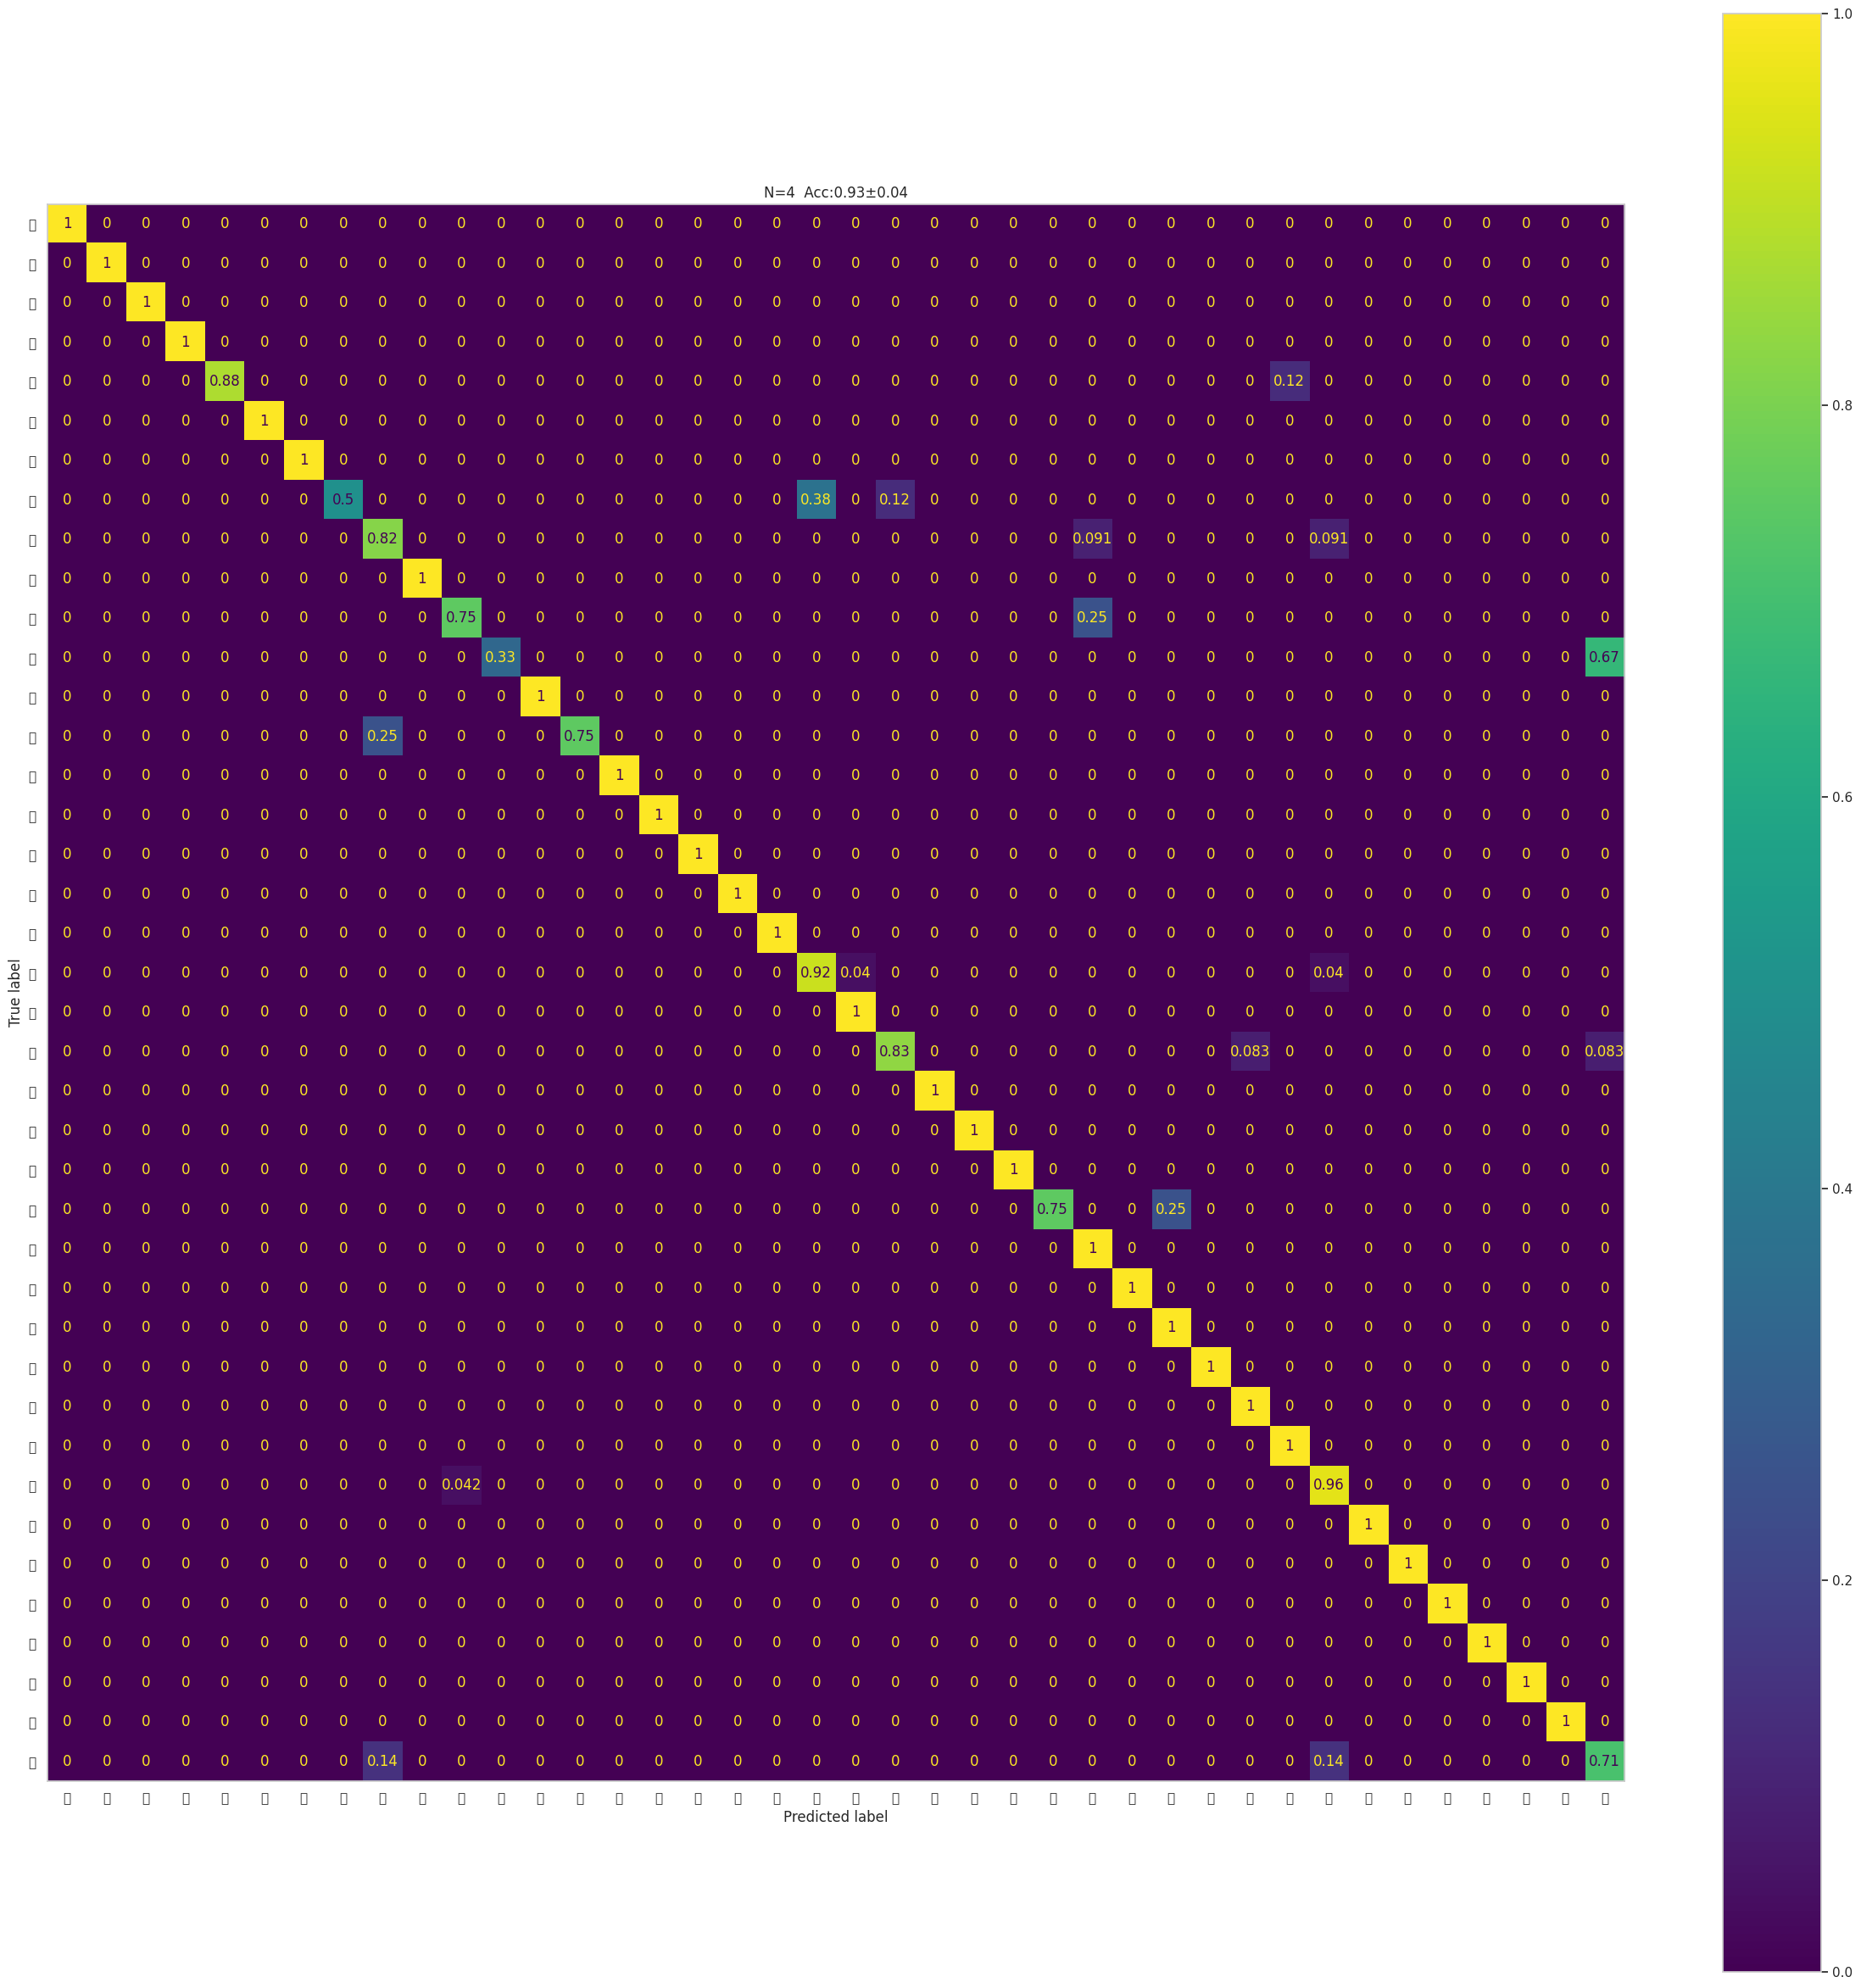

(7, 257) 257


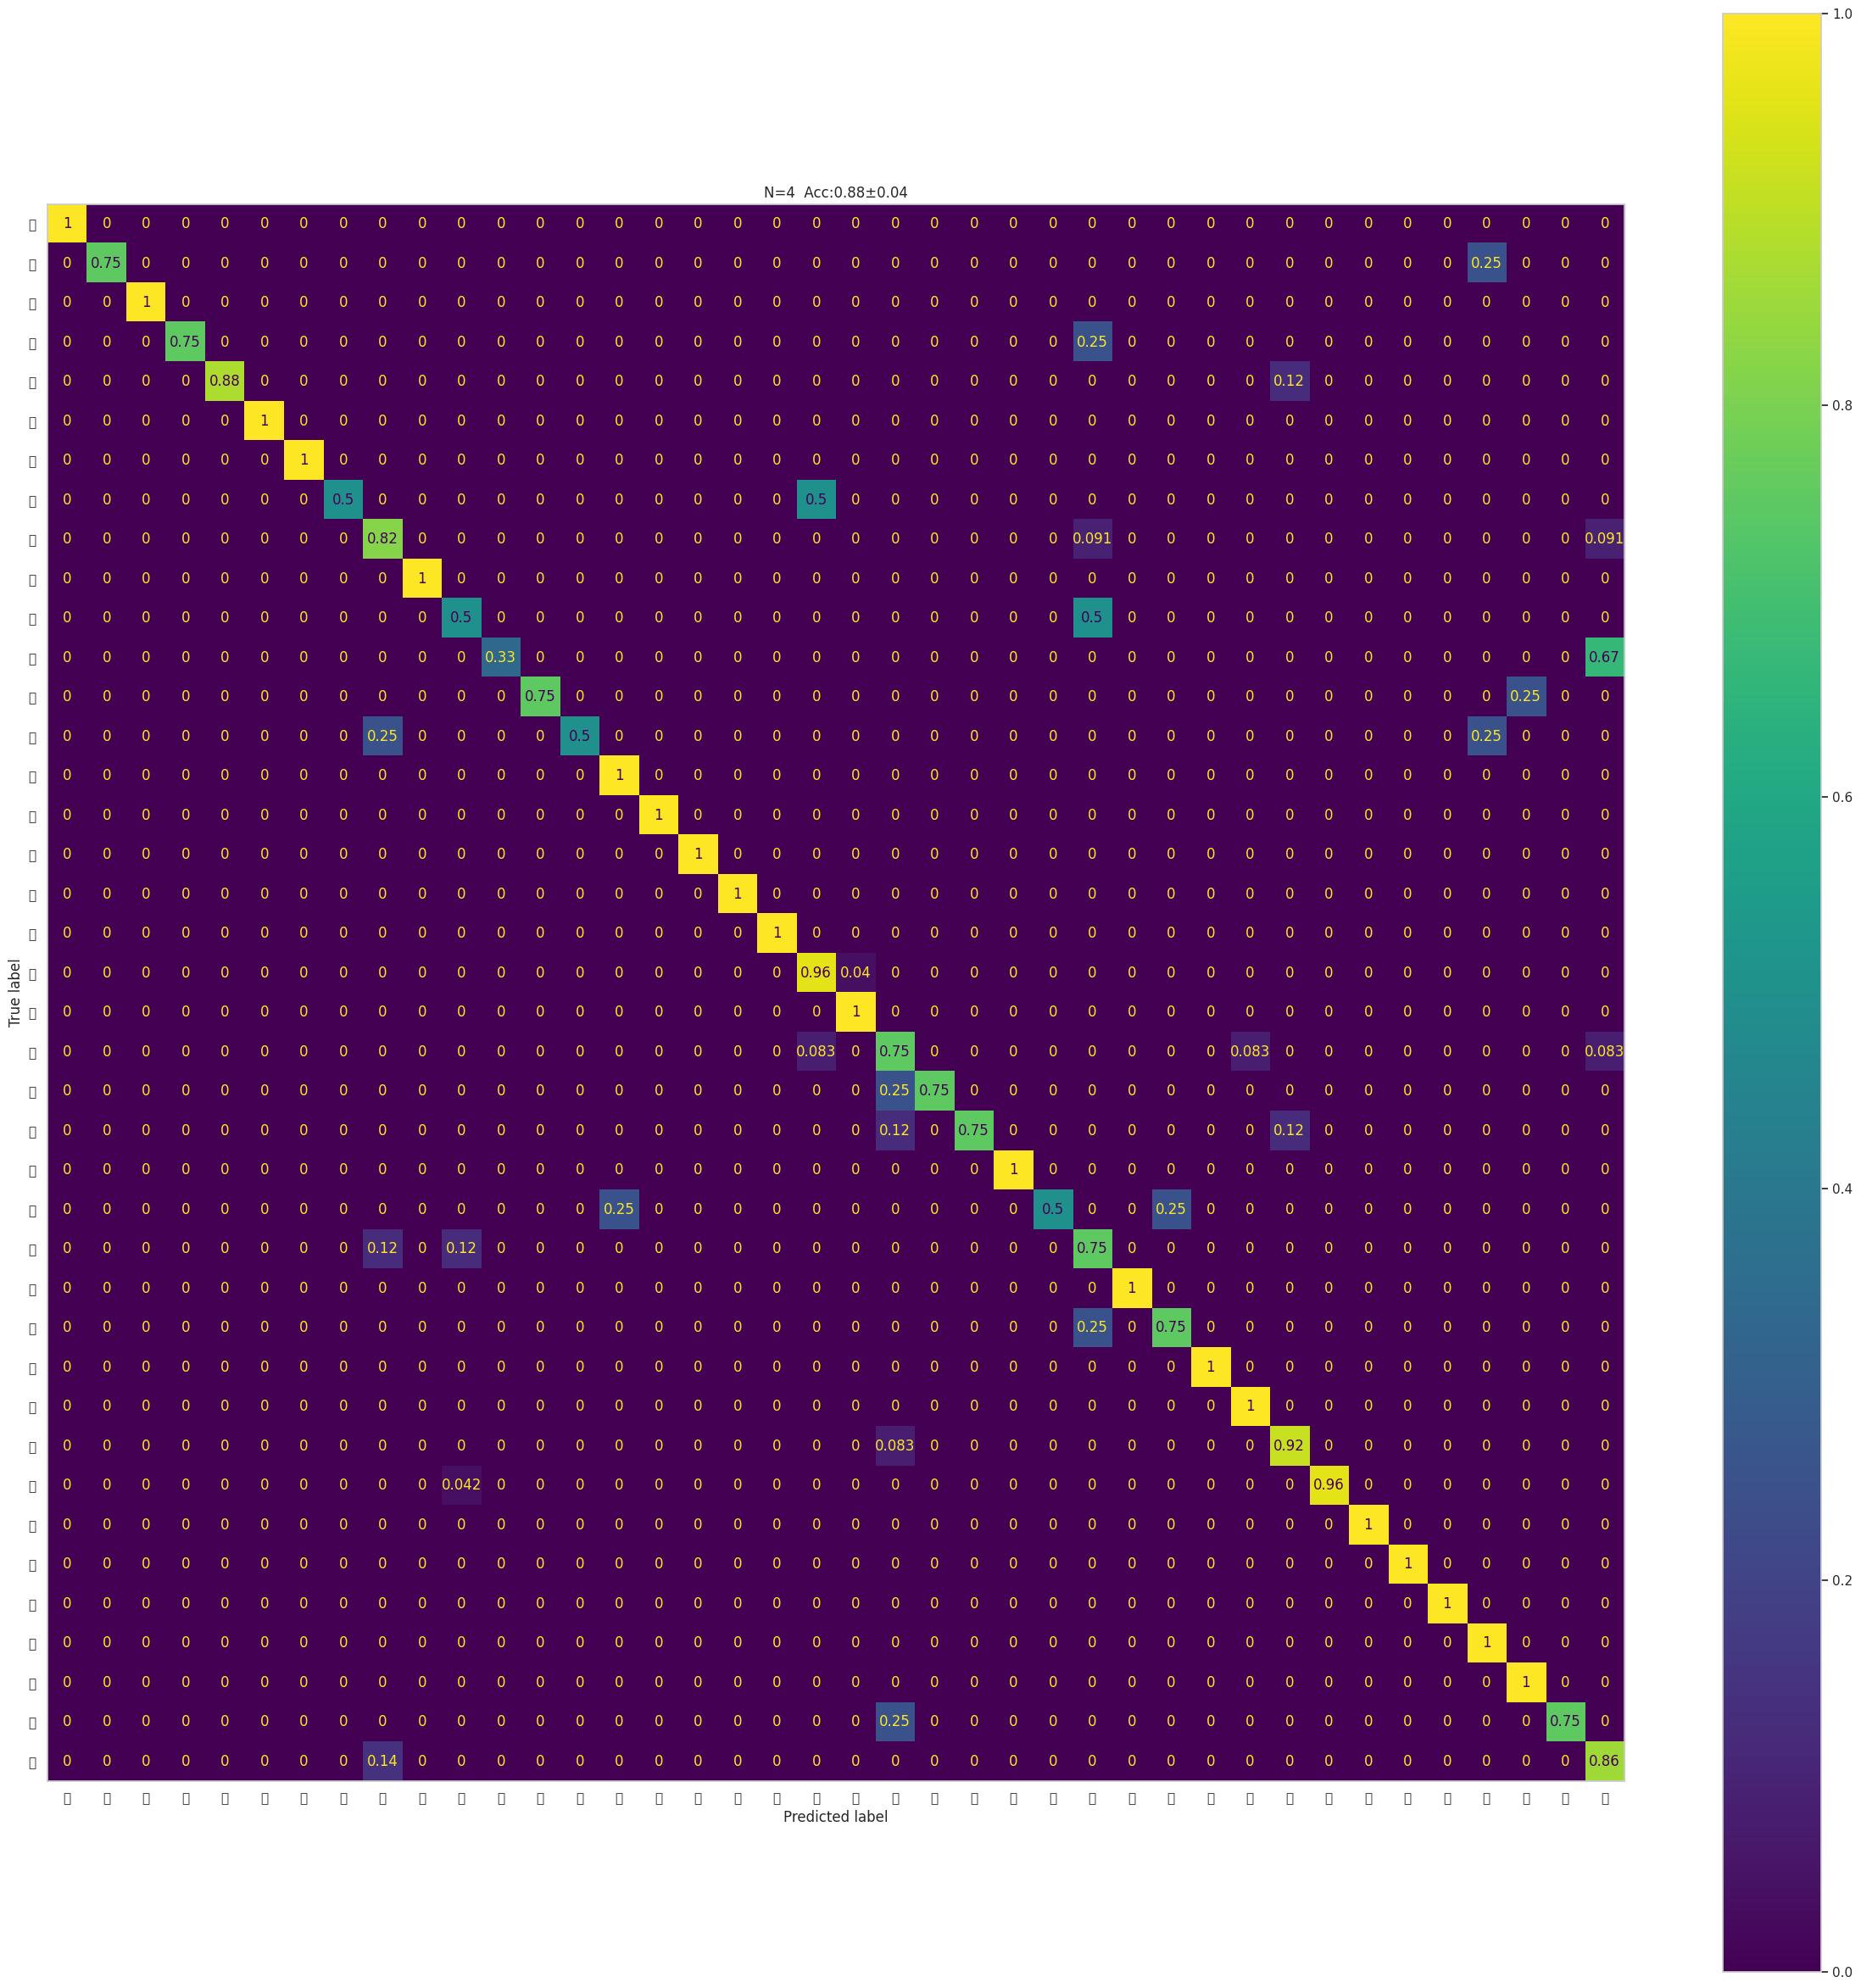

([0.859375, 0.859375, 0.84375, 0.953125], [16.0, 13.0, 14.0, 15.0])

In [36]:
fix_char_out = get_char_output(sylb_label_mat,fix_pred_prob_char,L_index)
print(sylb_label_mat.shape,len(fix_char_out))

stage = 'char'
#INSPECTION:
evaluater2(sylb_label_mat, fix_char_out, unit=3)

char_out = get_char_output(clipTimeMat,pred_prob_char,L_index)
print(clipTimeMat.shape,len(char_out))
stage = 'onset_char'
#INSPECTION:
evaluater2(clipTimeMat, char_out, unit=3)

In [37]:
#SAVE DATA
#np.save(subject+'_sylb_tone_pred.npy',np.array([sylb_tone_out,fix_sylb_tone_out]))###
sylb_tone_out,fix_sylb_tone_out = np.load(subject+'_sylb_tone_pred.npy',allow_pickle=True)###

#np.save(subject+'_char_pred.npy',np.array([pred_prob_char,fix_pred_prob_char,char_out,fix_char_out]))###
pred_prob_char,fix_pred_prob_char,char_out,fix_char_out = np.load(subject+'_char_pred.npy',allow_pickle=True)###

1.0
True: 他 哥 不 理 他                      Pred: 他 哥 不 理 他                      WER: 0.00 
2.0
True: 他 的 荔 枝 七 折 起                  Pred: 他 的 荔 枝 七 折 起                  WER: 0.00 
3.0
True: 哥 哥 不 时 地 激 励 他                Pred: 哥 哥 不 时 地 激 励 他                WER: 0.00 
4.0
True: 他 极 其 机 智                      Pred: 极 其 其 机 智                      WER: 0.40 
5.0
True: 织 布 机 是 这 里 的                  Pred: 织 布 机 是 这 里 的                  WER: 0.00 
6.0
True: 这 里 的 塔 是 个 奇 迹                Pred: 这 里 的 塔 这 个 契 机                WER: 0.38 
7.0
True: 智 者 不 计 得 失                    Pred: 智 者 不 止                        WER: 0.50 
8.0
True: 记 者 不 得 不 离 职                  Pred: 智 者 不 不 不 离 职                  WER: 0.29 
9.0
True: 搁 置 这 个 契 机                    Pred: 搁 置 这 个 契 机                    WER: 0.00 
10.0
True: 他 其 实 不 止 七 十                  Pred: 他 其 实 不 止 七 职                  WER: 0.14 
1.0
True: 他 哥 不 理 他                      Pred: 他 哥 不 理 他                      WER: 0.00 
2.0
True: 他 的 荔 枝 七 

0

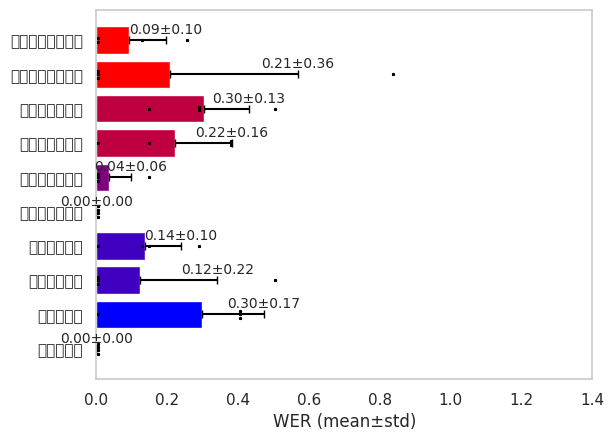

In [38]:
wer_mat = wer_evaluater(sylb_label_mat, clipTimeMat, char_out)
print(wer_mat.shape)

#INSPECT WERS OF EACH SENTENCE
plot_sentence_wer(wer_mat)

In [39]:
# SAVE DATA
#np.save(subject+'_wer_mat.npy',wer_mat)###
#np.save(subject+'_CNN_wer_mat.npy',wer_mat)###
#np.save(subject+'_RNN_wer_mat.npy',wer_mat)###
#np.save(subject+'_MED_wer_mat.npy',wer_mat)###
wer_mat = np.load(subject+'_wer_mat.npy',allow_pickle=True)###
print('AVERAGE WER:',np.nanmean(np.nanmean(wer_mat)))
#print(wer_mat.shape)

AVERAGE WER: 0.1427976205945015
